<a href="https://colab.research.google.com/github/NesquikPlz/kisa_rugpullpredection_xgboost/blob/main/kisa_rugpullpredetection_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import xgboost as xgb ## XGBoost 불러오기
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance ## Feature Importance를 불러오기 위함
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# import warnings
# warnings.filterwarnings('ignore')

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4


In [102]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [103]:
train = pd.read_csv('/content/drive/MyDrive/dataset/Dataset_v1.2.csv')
train = train.drop(columns = ['txcount', 'swap_count'])

In [104]:
train['Label'] = train['Label'].replace({True : 1, False : 0})

In [105]:
train = train.dropna(how='any',axis = 0)
train.isnull().sum()

Label                                  0
mint_count                             0
burn_count                             0
mint_ratio                             0
swap_ratio                             0
burn_ratio                             0
mint_mean_period                       0
swap_mean_period                       0
burn_mean_period                       0
swapIn                                 0
swapOut                                0
swap_rate                              0
LP_avg                                 0
LP_stdev                               0
LPCreator_holding_ratio                0
Lock_ratio                             0
Creator_token_holding_ratio            0
number_of_token_creation_of_Creator    0
dtype: int64

In [106]:
train

,Label,mint_count,burn_count,mint_ratio,swap_ratio,burn_ratio,mint_mean_period,swap_mean_period,burn_mean_period,swapIn,swapOut,swap_rate,LP_avg,LP_stdev,LPCreator_holding_ratio,Lock_ratio,Creator_token_holding_ratio,number_of_token_creation_of_Creator
0,1,1,1,0.000557,0.998885,3.276454e-02,0.000000,0.000412,1.000000,993,799,1.241250,100.0,0.000000,0.000016,9.999843e-01,1.040000e+56,1
1,1,2,0,0.333333,0.666667,0.000000e+00,0.497563,0.974927,0.000000,1,3,0.250000,100.0,0.000000,1.000000,1.378390e-09,9.541985e+06,1
2,1,1,0,0.023256,0.976744,1.818000e-15,0.000000,0.052364,0.000000,32,10,2.909091,100.0,0.000000,0.000000,1.000000e+00,1.262068e+05,1
3,1,2,1,0.036364,0.945455,0.000000e+00,0.010866,0.196500,0.041141,42,10,3.818182,100.0,0.000000,0.500000,5.000000e-01,6.250000e+03,1
4,1,2,1,0.011765,0.982353,0.000000e+00,0.026315,0.425491,0.900897,121,46,2.574468,100.0,0.000000,0.000000,1.000000e+00,6.250000e+03,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8672,0,7,0,0.011765,0.988235,3.452232e-03,0.335801,0.551373,0.000000,325,263,1.231061,25.0,28.666254,0.254087,0.000000e+00,1.663639e+00,1
8673,0,1,0,0.001126,0.998874,0.000000e+00,0.000000,0.207591,0.000000,497,390,1.271100,100.0,0.000000,1.000000,0.000000e+00,9.210909e-01,1
8674,0,1,1,0.200000,0.600000,0.000000e+00,0.000000,0.245536,1.000000,3,0,3.000000,100.0,0.000000,1.000000,0.000000e+00,8.019433e-01,1
8675,0,7,1,0.155556,0.822222,0.000000e+00,0.345336,0.399549,0.140687,6,31,0.187500,25.0,26.411528,0.000897,5.711964e-12,8.000080e-01,1


In [107]:
# train = train.astype(np.float32)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8673 entries, 0 to 8676
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Label                                8673 non-null   int64  
 1   mint_count                           8673 non-null   int64  
 2   burn_count                           8673 non-null   int64  
 3   mint_ratio                           8673 non-null   float64
 4   swap_ratio                           8673 non-null   float64
 5   burn_ratio                           8673 non-null   float64
 6   mint_mean_period                     8673 non-null   float64
 7   swap_mean_period                     8673 non-null   float64
 8   burn_mean_period                     8673 non-null   float64
 9   swapIn                               8673 non-null   int64  
 10  swapOut                              8673 non-null   int64  
 11  swap_rate                     

In [108]:
#creating deepcopy of model instances
from copy import deepcopy

#array manipulations
import numpy as np

#dataframe and its manipulations
import pandas as pd

#plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#selected plotting functions
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

#classes for grid search and cross-validation, function for splitting data and evaluating models
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split
from skopt import BayesSearchCV
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,confusion_matrix,roc_curve

#XGBoost library
import xgboost as xgb

#Python standard libraries
import time
import warnings

#setting default resolution of figures
mpl.rcParams['figure.dpi'] = 200

In [109]:
# pip install -e git+https://github.com/scikit-learn/scikit-learn.git#egg=scikit-learn-0.18dev

In [110]:
# pip install scikit-optimize

In [111]:
X = train.drop(columns = ['Label'])
y = train['Label']

In [112]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=777)

### https://towardsdatascience.com/binary-classification-xgboost-hyperparameter-tuning-scenarios-by-non-exhaustive-grid-search-and-c261f4ce098d

In [113]:
import time

#dictionary for collecting results
results_dict = {}

#obtaining default parameters by calling .fit() to XGBoost model instance
xgbc0 = xgb.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False)
xgbc0.fit(X_train , y_train)

#extracting default parameters from benchmark model
default_params = {}
gparams = xgbc0.get_params()

#default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
for key in gparams.keys():
    gp = gparams[key]
    default_params[key] = [gp]

#benchmark model. Grid search is not performed, since only single values are provided as parameter grid.
#However, cross-validation is still executed
clf0 = GridSearchCV(estimator=xgbc0, scoring='accuracy', param_grid=default_params, return_train_score=True, verbose=1, cv=3)
clf0.fit(X_train, y_train.values.ravel())

#results dataframe
df = pd.DataFrame(clf0.cv_results_)

#predictions - inputs to confusion matrix
train_predictions = clf0.predict(X_train)
test_predictions = clf0.predict(X_test)
# unseen_predictions = clf0.predict(df_test.iloc[:,1:])

#confusion matrices
cfm_train = confusion_matrix(y_train, train_predictions)
cfm_test = confusion_matrix(y_test, test_predictions)
# cfm_unseen = confusion_matrix(df_test.iloc[:,:1], unseen_predictions)

#accuracy scores
accs_train = accuracy_score(y_train, train_predictions)
accs_test = accuracy_score(y_test, test_predictions)
# accs_unseen = accuracy_score(df_test.iloc[:,:1], unseen_predictions)

#F1 scores for each train/test label
f1s_train_p1 = f1_score(y_train, train_predictions, pos_label=1)
f1s_train_p0 = f1_score(y_train, train_predictions, pos_label=0)
f1s_test_p1 = f1_score(y_test, test_predictions, pos_label=1)
f1s_test_p0 = f1_score(y_test, test_predictions, pos_label=0)
# f1s_unseen_p1 = f1_score(df_test.iloc[:,:1], unseen_predictions, pos_label=1)
# f1s_unseen_p0 = f1_score(df_test.iloc[:,:1], unseen_predictions, pos_label=0)

#Area Under the Receiver Operating Characteristic Curve
test_ras = roc_auc_score(y_test, clf0.predict_proba(X_test)[:,1])
# unseen_ras = roc_auc_score(df_test.iloc[:,:1], clf0.predict_proba(df_test.iloc[:,1:])[:,1])

#best parameters
bp = clf0.best_params_

#storing computed values in results dictionary
results_dict['xgbc0'] = {'iterable_parameter': np.nan,
                         'classifier': deepcopy(clf0),
                         'cv_results': df.copy(),
                         'cfm_train': cfm_train,
                         'cfm_test': cfm_test,
                        #  'cfm_unseen': cfm_unseen,
                         'train_accuracy': accs_train,
                         'test_accuracy': accs_test,
                        #  'unseen_accuracy': accs_unseen,
                         'train F1-score label 1': f1s_train_p1,
                         'train F1-score label 0': f1s_train_p0,
                         'test F1-score label 1': f1s_test_p1,
                         'test F1-score label 0': f1s_test_p0,
                        #  'unseen F1-score label 1': f1s_unseen_p1,
                        #  'unseen F1-score label 0': f1s_unseen_p0,
                         'test roc auc score': test_ras,
                        #  'unseen roc auc score': unseen_ras,
                         'best_params': bp}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s finished


In [114]:
params = deepcopy(default_params)

#setting grid of selected parameters for iteration
param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [50,65,80,100,115,130,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}

In [115]:
t0 = time.time()
#No. of jobs
gcvj = np.cumsum([len(x) for x in param_grid.values()])[-1]

#iteration loop. Each selected parameter iterated separately
for i,grid_key in enumerate(param_grid.keys()):
    
    #variable for measuring iteration time
    loop_start = time.time()
       
    #creating param_grid argument for GridSearchCV:
    #listing grid values of current iterable parameter and wrapping non-iterable parameter single values in list
    for param_key in params.keys():
        if param_key == grid_key:
            params[param_key] = param_grid[grid_key]
        else:
            #use best parameters of last iteration
            try:
                param_value = [clf.best_params_[param_key]]
                params[param_key] = param_value
            #use benchmark model parameters for first iteration
            except:
                param_value = [clf0.best_params_[param_key]]
                params[param_key] = param_value
    
    #classifier instance of current iteration
    xgbc = xgb.XGBClassifier(**default_params)
    
    #GridSearch instance of current iteration
    clf = GridSearchCV(estimator=xgbc, param_grid=params, scoring='accuracy', return_train_score=True, verbose=1, cv=3)
    clf.fit(X_train, y_train.values.ravel())
    
    #results dataframe
    df = pd.DataFrame(clf.cv_results_)
    
    #predictions - inputs to confusion matrix
    train_predictions = clf.predict(X_train)
    test_predictions = clf.predict(X_test)
    # unseen_predictions = clf.predict(df_test.iloc[:,1:])
    
    #confusion matrices
    cfm_train = confusion_matrix(y_train, train_predictions)
    cfm_test = confusion_matrix(y_test, test_predictions)
    # cfm_unseen = confusion_matrix(df_test.iloc[:,:1], unseen_predictions)
    
    #accuracy scores
    accs_train = accuracy_score(y_train, train_predictions)
    accs_test = accuracy_score(y_test, test_predictions)
    # accs_unseen = accuracy_score(df_test.iloc[:,:1], unseen_predictions)
    
    #F1 scores for each train/test label
    f1s_train_p1 = f1_score(y_train, train_predictions, pos_label=1)
    f1s_train_p0 = f1_score(y_train, train_predictions, pos_label=0)
    f1s_test_p1 = f1_score(y_test, test_predictions, pos_label=1)
    f1s_test_p0 = f1_score(y_test, test_predictions, pos_label=0)
    # f1s_unseen_p1 = f1_score(df_test.iloc[:,:1], unseen_predictions, pos_label=1)
    # f1s_unseen_p0 = f1_score(df_test.iloc[:,:1], unseen_predictions, pos_label=0)
    
    #Area Under the Receiver Operating Characteristic Curve
    test_ras = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
    # unseen_ras = roc_auc_score(df_test.iloc[:,:1], clf.predict_proba(df_test.iloc[:,1:])[:,1])
    
    #best parameters
    bp = clf.best_params_
    
    #storing computed values in results dictionary
    results_dict[f'xgbc{i+1}'] = {'iterable_parameter': grid_key,
                                  'classifier': deepcopy(clf),
                                  'cv_results': df.copy(),
                                  'cfm_train': cfm_train,
                                  'cfm_test': cfm_test,
                                  # 'cfm_unseen': cfm_unseen,
                                  'train_accuracy': accs_train,
                                  'test_accuracy': accs_test,
                                  # 'unseen_accuracy': accs_unseen,
                                  'train F1-score label 1': f1s_train_p1,
                                  'train F1-score label 0': f1s_train_p0,
                                  'test F1-score label 1': f1s_test_p1,
                                  'test F1-score label 0': f1s_test_p0,
                                  # 'unseen F1-score label 1': f1s_unseen_p1,
                                  # 'unseen F1-score label 0': f1s_unseen_p0,
                                  'test roc auc score': test_ras,
                                  # 'unseen roc auc score': unseen_ras,
                                  'best_params': bp}
    
    #variable for measuring iteration time
    elapsed_time = time.time() - loop_start
    print(f'iteration #{i+1} finished in: {elapsed_time} seconds')

#stop time
t1 = time.time()

#elapsed time
gcvt = t1 - t0

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:   21.0s finished


iteration #1 finished in: 21.73479700088501 seconds
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   19.0s finished


iteration #2 finished in: 19.52596664428711 seconds
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   15.7s finished


iteration #3 finished in: 16.228400230407715 seconds
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    8.2s finished


iteration #4 finished in: 8.535993576049805 seconds
Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:    6.1s finished


iteration #5 finished in: 6.474100351333618 seconds
Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:    9.1s finished


iteration #6 finished in: 9.425438642501831 seconds


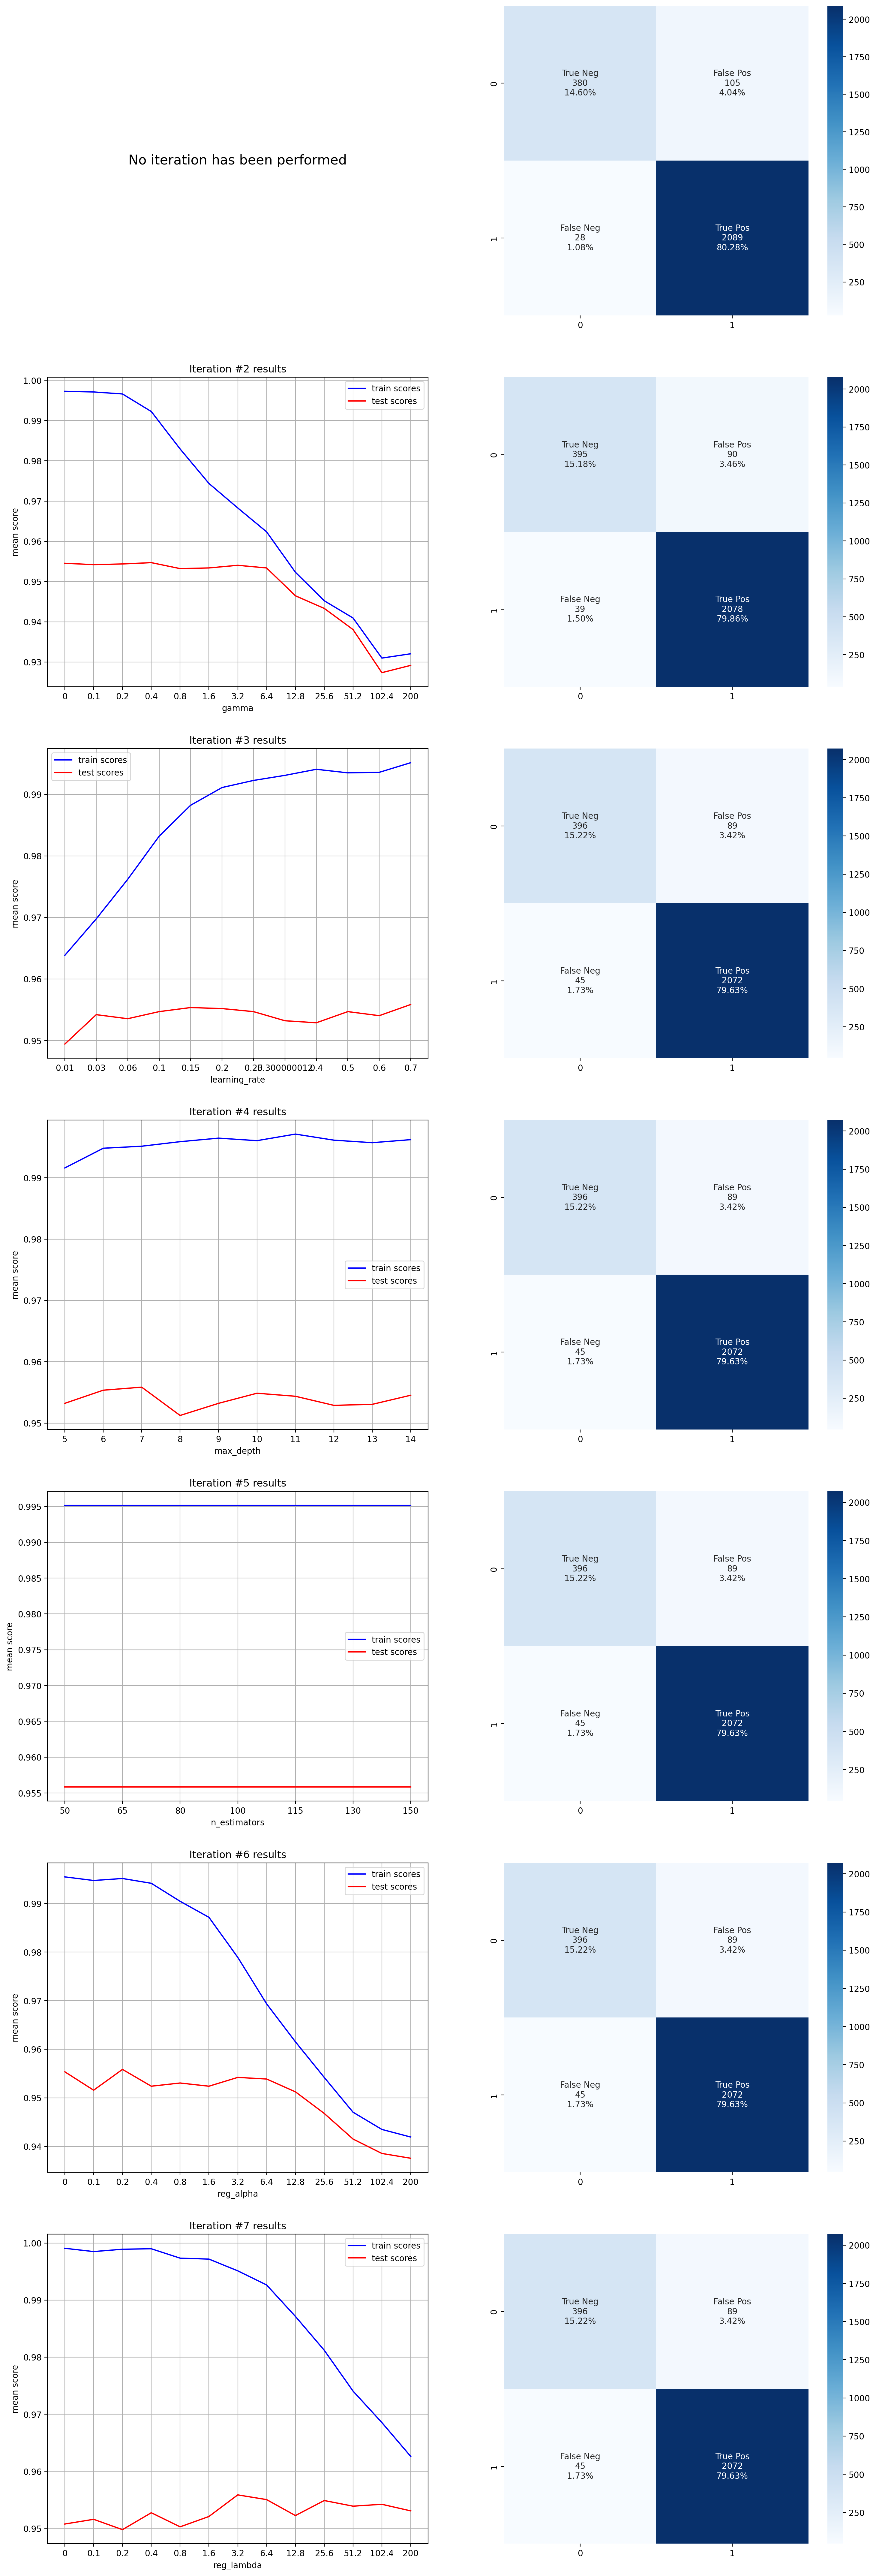

In [116]:
#number of rows depend on number of iterations
nrows = len(results_dict.keys())

#standard group names for confusion matrices
group_names = ['True Neg','False Pos','False Neg','True Pos']

#creating figure
f, axes = plt.subplots(nrows,2,figsize=(18,8*nrows));

#iteratively plotting train/test accuracy scores and test confusion matrix
for i,ax in enumerate(axes):
    
    #current key of results dictionary
    ckey = list(results_dict.keys())[i] 
    
    #plotting scores for models other than the benchark model
    if ckey != 'xgbc0':
        x1 = results_dict[ckey]['cv_results'].loc[:,'mean_train_score']
        x2 = results_dict[ckey]['cv_results'].loc[:,'mean_test_score']
        
        ax[0].plot(x1, label='train scores', color='blue');
        ax[0].plot(x2, label='test scores', color='red');
        ax[0].set_title(f'Iteration #{i+1} results');
               
        ax[0].set_xticks(list(range(0,len([x[results_dict[ckey]['iterable_parameter']] for x in results_dict[ckey]['cv_results']['params']]))));
        ax[0].set_xticklabels(sorted([x[results_dict[ckey]['iterable_parameter']] for x in results_dict[ckey]['cv_results']['params']]));
    
        ax[0].grid('major');
        ax[0].legend();
        ax[0].set_xlabel(results_dict[ckey]['iterable_parameter'])
        ax[0].set_ylabel('mean score');
    
    #leaving scores plot blank for benchmark model
    else:
        ax[0].axis('off')
        ax[0].text(x=0.5, y=0.5, s='No iteration has been performed', fontsize=16, va='center', ha='center')
    
    #computing variables for specific confusion matrix
    group_counts = ["{0:0.0f}".format(value) for value in results_dict[ckey]['cfm_test'].flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in results_dict[ckey]['cfm_test'].flatten()/np.sum(results_dict[ckey]['cfm_test'])]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    #plotting confusion matrix
    sns.heatmap(results_dict[ckey]['cfm_test'], annot=labels, fmt='', cmap='Blues', ax=ax[1])
    
plt.show();

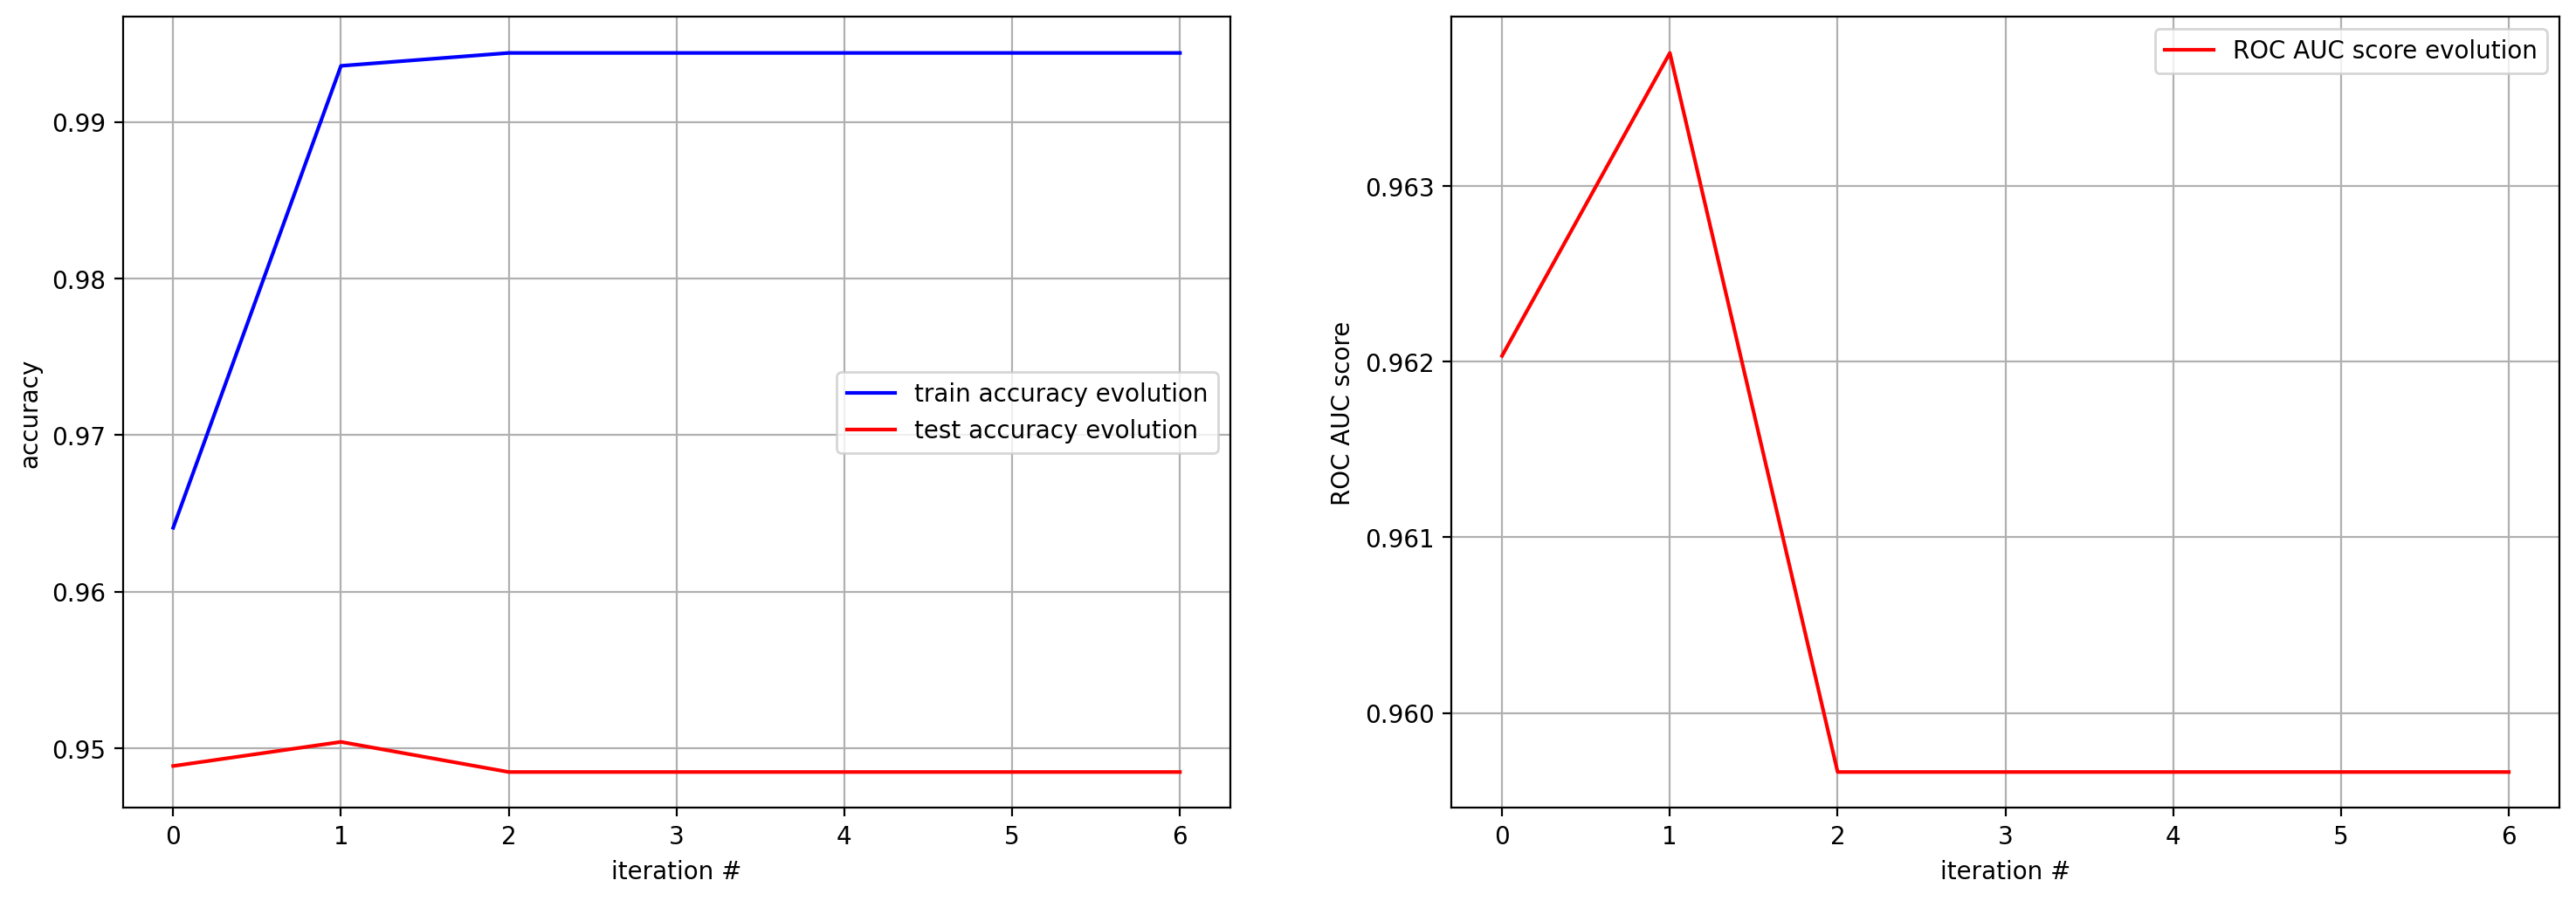

In [117]:
f, axes = plt.subplots(1,2,figsize=(18,6));

#plotting evolution of train/test accuracy scores for subsequent iterations
axes[0].plot([results_dict[key]['train_accuracy'] for key in results_dict.keys()], label='train accuracy evolution', color='blue');
axes[0].plot([results_dict[key]['test_accuracy'] for key in results_dict.keys()], label='test accuracy evolution', color='red');

#setting labels, drawing legend and major grid
axes[0].set_xlabel('iteration #');
axes[0].set_ylabel('accuracy');
axes[0].legend();
axes[0].grid('major');

#plotting evolution of test ROC AUC scores for subsequent iterations
axes[1].plot([results_dict[key]['test roc auc score'] for key in results_dict.keys()], label='ROC AUC score evolution', color='red');

#setting labels, drawing legend and major grid
axes[1].set_xlabel('iteration #');
axes[1].set_ylabel('ROC AUC score');
axes[1].legend();
axes[1].grid('major');

plt.show();

In [120]:

#start time
t0 = time.time()

#No. of jobs
rcvj = gcvj

#unwrapping list values of default parameters
default_params_xgb = {}

for key in default_params.keys():
    default_params_xgb[key] = default_params[key][0]

#providing default parameters to xgbc model, before randomized search cross-validation
xgbc = xgb.XGBClassifier(**default_params_xgb)

#Executing Randomized Search
clf = RandomizedSearchCV(estimator=xgbc, param_distributions=param_grid, scoring='accuracy', return_train_score=True, verbose=1, cv=3, n_iter=rcvj)
clf.fit(X_train, y_train.values.ravel())
    
#results dataframe
df = pd.DataFrame(clf.cv_results_)
    
#predictions - inputs to confusion matrix
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)
# unseen_predictions = clf.predict(df_test.iloc[:,1:])
    
#confusion matrices
cfm_train = confusion_matrix(y_train, train_predictions)
cfm_test = confusion_matrix(y_test, test_predictions)
# cfm_unseen = confusion_matrix(df_test.iloc[:,:1], unseen_predictions)
    
#accuracy scores
accs_train = accuracy_score(y_train, train_predictions)
accs_test = accuracy_score(y_test, test_predictions)
# accs_unseen = accuracy_score(df_test.iloc[:,:1], unseen_predictions)
    
#F1 scores for each train/test label
f1s_train_p1 = f1_score(y_train, train_predictions, pos_label=1)
f1s_train_p0 = f1_score(y_train, train_predictions, pos_label=0)
f1s_test_p1 = f1_score(y_test, test_predictions, pos_label=1)
f1s_test_p0 = f1_score(y_test, test_predictions, pos_label=0)
# f1s_unseen_p1 = f1_score(df_test.iloc[:,:1], unseen_predictions, pos_label=1)
# f1s_unseen_p0 = f1_score(df_test.iloc[:,:1], unseen_predictions, pos_label=0)
    
#Area Under the Receiver Operating Characteristic Curve
test_ras = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
# unseen_ras = roc_auc_score(df_test.iloc[:,:1], clf.predict_proba(df_test.iloc[:,1:])[:,1])
    
#best parameters
bp = clf.best_params_
    
#storing computed values in results dictionary
results_dict['xgbc_rcv'] = {'classifier': deepcopy(clf),
                            'cv_results': df.copy(),
                            'cfm_train': cfm_train,
                            'cfm_test': cfm_test,
                            # 'cfm_unseen': cfm_unseen,
                            'train_accuracy': accs_train,
                            'test_accuracy': accs_test,
                            # 'unseen_accuracy': accs_unseen,
                            'train F1-score label 1': f1s_train_p1,
                            'train F1-score label 0': f1s_train_p0,
                            'test F1-score label 1': f1s_test_p1,
                            'test F1-score label 0': f1s_test_p0,
                            # 'unseen F1-score label 1': f1s_unseen_p1,
                            # 'unseen F1-score label 0': f1s_unseen_p0,
                            'test roc auc score': test_ras,
                            # 'unseen roc auc score': unseen_ras,
                            'best_params': bp}

#stop time
t1 = time.time()

#elapsed time
rcvt = t1 - t0

Fitting 3 folds for each of 68 candidates, totalling 204 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 204 out of 204 | elapsed:  1.4min finished


In [121]:

#start time
t0 = time.time()

#No. of jobs
bcvj = int(gcvj)

#unwrapping list values of default parameters
default_params_xgb = {}

for key in default_params.keys():
    default_params_xgb[key] = default_params[key][0]

#providing default parameters to xgbc model, before randomized search cross-validation
xgbc = xgb.XGBClassifier(**default_params_xgb)

clf = BayesSearchCV(estimator=xgbc, search_spaces=param_grid, n_iter=bcvj, scoring='accuracy', cv=3, return_train_score=True, verbose=3)
clf.fit(X_train, y_train.values.ravel())

#results dataframe
df = pd.DataFrame(clf.cv_results_)
    
#predictions - inputs to confusion matrix
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)
# unseen_predictions = clf.predict(df_test.iloc[:,1:])
    
#confusion matrices
cfm_train = confusion_matrix(y_train, train_predictions)
cfm_test = confusion_matrix(y_test, test_predictions)
# cfm_unseen = confusion_matrix(df_test.iloc[:,:1], unseen_predictions)
    
#accuracy scores
accs_train = accuracy_score(y_train, train_predictions)
accs_test = accuracy_score(y_test, test_predictions)
# accs_unseen = accuracy_score(df_test.iloc[:,:1], unseen_predictions)
    
#F1 scores for each train/test label
f1s_train_p1 = f1_score(y_train, train_predictions, pos_label=1)
f1s_train_p0 = f1_score(y_train, train_predictions, pos_label=0)
f1s_test_p1 = f1_score(y_test, test_predictions, pos_label=1)
f1s_test_p0 = f1_score(y_test, test_predictions, pos_label=0)
# f1s_unseen_p1 = f1_score(df_test.iloc[:,:1], unseen_predictions, pos_label=1)
# f1s_unseen_p0 = f1_score(df_test.iloc[:,:1], unseen_predictions, pos_label=0)
    
#Area Under the Receiver Operating Characteristic Curve
test_ras = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
# unseen_ras = roc_auc_score(df_test.iloc[:,:1], clf.predict_proba(df_test.iloc[:,1:])[:,1])
    
#best parameters
bp = clf.best_params_
    
#storing computed values in results dictionary
results_dict['xgbc_bcv'] = {'classifier': deepcopy(clf),
                            'cv_results': df.copy(),
                            'cfm_train': cfm_train,
                            'cfm_test': cfm_test,
                            # 'cfm_unseen': cfm_unseen,
                            'train_accuracy': accs_train,
                            'test_accuracy': accs_test,
                            # 'unseen_accuracy': accs_unseen,
                            'train F1-score label 1': f1s_train_p1,
                            'train F1-score label 0': f1s_train_p0,
                            'test F1-score label 1': f1s_test_p1,
                            'test F1-score label 0': f1s_test_p0,
                            # 'unseen F1-score label 1': f1s_unseen_p1,
                            # 'unseen F1-score label 0': f1s_unseen_p0,
                            'test roc auc score': test_ras,
                            # 'unseen roc auc score': unseen_ras,
                            'best_params': bp}

#stop time
t1 = time.time()

#elapsed time
bcvt = t1 - t0

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=3.2, learning_rate=0.15, max_depth=13, n_estimators=115, reg_alpha=6.4, reg_lambda=0.1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=3.2, learning_rate=0.15, max_depth=13, n_estimators=115, reg_alpha=6.4, reg_lambda=0.1, score=(train=0.960, test=0.950), total=   0.6s
[CV] gamma=3.2, learning_rate=0.15, max_depth=13, n_estimators=115, reg_alpha=6.4, reg_lambda=0.1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  gamma=3.2, learning_rate=0.15, max_depth=13, n_estimators=115, reg_alpha=6.4, reg_lambda=0.1, score=(train=0.958, test=0.960), total=   0.7s
[CV] gamma=3.2, learning_rate=0.15, max_depth=13, n_estimators=115, reg_alpha=6.4, reg_lambda=0.1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV]  gamma=3.2, learning_rate=0.15, max_depth=13, n_estimators=115, reg_alpha=6.4, reg_lambda=0.1, score=(train=0.960, test=0.942), total=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.4, learning_rate=0.03, max_depth=14, n_estimators=65, reg_alpha=0.4, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.4, learning_rate=0.03, max_depth=14, n_estimators=65, reg_alpha=0.4, reg_lambda=0.2, score=(train=0.980, test=0.951), total=   0.6s
[CV] gamma=0.4, learning_rate=0.03, max_depth=14, n_estimators=65, reg_alpha=0.4, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.03, max_depth=14, n_estimators=65, reg_alpha=0.4, reg_lambda=0.2, score=(train=0.977, test=0.958), total=   0.7s
[CV] gamma=0.4, learning_rate=0.03, max_depth=14, n_estimators=65, reg_alpha=0.4, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.03, max_depth=14, n_estimators=65, reg_alpha=0.4, reg_lambda=0.2, score=(train=0.979, test=0.945), total=   0.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=3.2, learning_rate=0.15, max_depth=13, n_estimators=115, reg_alpha=0.8, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=3.2, learning_rate=0.15, max_depth=13, n_estimators=115, reg_alpha=0.8, reg_lambda=3.2, score=(train=0.967, test=0.956), total=   0.9s
[CV] gamma=3.2, learning_rate=0.15, max_depth=13, n_estimators=115, reg_alpha=0.8, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  gamma=3.2, learning_rate=0.15, max_depth=13, n_estimators=115, reg_alpha=0.8, reg_lambda=3.2, score=(train=0.964, test=0.961), total=   1.0s
[CV] gamma=3.2, learning_rate=0.15, max_depth=13, n_estimators=115, reg_alpha=0.8, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s


[CV]  gamma=3.2, learning_rate=0.15, max_depth=13, n_estimators=115, reg_alpha=0.8, reg_lambda=3.2, score=(train=0.969, test=0.947), total=   0.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.0, learning_rate=0.1, max_depth=6, n_estimators=130, reg_alpha=6.4, reg_lambda=102.4 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.0, learning_rate=0.1, max_depth=6, n_estimators=130, reg_alpha=6.4, reg_lambda=102.4, score=(train=0.961, test=0.952), total=   0.5s
[CV] gamma=0.0, learning_rate=0.1, max_depth=6, n_estimators=130, reg_alpha=6.4, reg_lambda=102.4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.1, max_depth=6, n_estimators=130, reg_alpha=6.4, reg_lambda=102.4, score=(train=0.958, test=0.960), total=   0.4s
[CV] gamma=0.0, learning_rate=0.1, max_depth=6, n_estimators=130, reg_alpha=6.4, reg_lambda=102.4 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.1, max_depth=6, n_estimators=130, reg_alpha=6.4, reg_lambda=102.4, score=(train=0.962, test=0.944), total=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=1.6, learning_rate=0.7, max_depth=5, n_estimators=80, reg_alpha=1.6, reg_lambda=12.8 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=1.6, learning_rate=0.7, max_depth=5, n_estimators=80, reg_alpha=1.6, reg_lambda=12.8, score=(train=0.968, test=0.955), total=   0.4s
[CV] gamma=1.6, learning_rate=0.7, max_depth=5, n_estimators=80, reg_alpha=1.6, reg_lambda=12.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  gamma=1.6, learning_rate=0.7, max_depth=5, n_estimators=80, reg_alpha=1.6, reg_lambda=12.8, score=(train=0.962, test=0.958), total=   0.2s
[CV] gamma=1.6, learning_rate=0.7, max_depth=5, n_estimators=80, reg_alpha=1.6, reg_lambda=12.8 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV]  gamma=1.6, learning_rate=0.7, max_depth=5, n_estimators=80, reg_alpha=1.6, reg_lambda=12.8, score=(train=0.966, test=0.946), total=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, reg_alpha=12.8, reg_lambda=25.6 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, reg_alpha=12.8, reg_lambda=25.6, score=(train=0.958, test=0.952), total=   0.2s
[CV] gamma=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, reg_alpha=12.8, reg_lambda=25.6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, reg_alpha=12.8, reg_lambda=25.6, score=(train=0.955, test=0.958), total=   0.3s
[CV] gamma=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, reg_alpha=12.8, reg_lambda=25.6 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, reg_alpha=12.8, reg_lambda=25.6, score=(train=0.959, test=0.939), total=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=25.6, learning_rate=0.6, max_depth=11, n_estimators=150, reg_alpha=0.1, reg_lambda=12.8 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=25.6, learning_rate=0.6, max_depth=11, n_estimators=150, reg_alpha=0.1, reg_lambda=12.8, score=(train=0.942, test=0.942), total=   0.9s
[CV] gamma=25.6, learning_rate=0.6, max_depth=11, n_estimators=150, reg_alpha=0.1, reg_lambda=12.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  gamma=25.6, learning_rate=0.6, max_depth=11, n_estimators=150, reg_alpha=0.1, reg_lambda=12.8, score=(train=0.940, test=0.952), total=   1.0s
[CV] gamma=25.6, learning_rate=0.6, max_depth=11, n_estimators=150, reg_alpha=0.1, reg_lambda=12.8 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s


[CV]  gamma=25.6, learning_rate=0.6, max_depth=11, n_estimators=150, reg_alpha=0.1, reg_lambda=12.8, score=(train=0.945, test=0.929), total=   1.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.8, learning_rate=0.15, max_depth=5, n_estimators=50, reg_alpha=6.4, reg_lambda=0.2 
[CV]  gamma=0.8, learning_rate=0.15, max_depth=5, n_estimators=50, reg_alpha=6.4, reg_lambda=0.2, score=(train=0.963, test=0.953), total=   0.2s
[CV] gamma=0.8, learning_rate=0.15, max_depth=5, n_estimators=50, reg_alpha=6.4, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.15, max_depth=5, n_estimators=50, reg_alpha=6.4, reg_lambda=0.2, score=(train=0.961, test=0.961), total=   0.2s
[CV] gamma=0.8, learning_rate=0.15, max_depth=5, n_estimators=50, reg_alpha=6.4, reg_lambda=0.2 
[CV]  gamma=0.8, learning_rate=0.15, max_depth=5, n_estimators=50, reg_alpha=6.4, reg_lambda=0.2, score=(train=0.966, test=0.946), total=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=6.4, learning_rate=0.06, max_depth=10, n_estimators=115, reg_alpha=102.4, reg_lambda=102.4 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=6.4, learning_rate=0.06, max_depth=10, n_estimators=115, reg_alpha=102.4, reg_lambda=102.4, score=(train=0.934, test=0.931), total=   0.3s
[CV] gamma=6.4, learning_rate=0.06, max_depth=10, n_estimators=115, reg_alpha=102.4, reg_lambda=102.4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  gamma=6.4, learning_rate=0.06, max_depth=10, n_estimators=115, reg_alpha=102.4, reg_lambda=102.4, score=(train=0.926, test=0.935), total=   0.3s
[CV] gamma=6.4, learning_rate=0.06, max_depth=10, n_estimators=115, reg_alpha=102.4, reg_lambda=102.4 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV]  gamma=6.4, learning_rate=0.06, max_depth=10, n_estimators=115, reg_alpha=102.4, reg_lambda=102.4, score=(train=0.941, test=0.925), total=   0.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=3.2, learning_rate=0.1, max_depth=6, n_estimators=65, reg_alpha=25.6, reg_lambda=25.6 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=3.2, learning_rate=0.1, max_depth=6, n_estimators=65, reg_alpha=25.6, reg_lambda=25.6, score=(train=0.947, test=0.944), total=   0.2s
[CV] gamma=3.2, learning_rate=0.1, max_depth=6, n_estimators=65, reg_alpha=25.6, reg_lambda=25.6 
[CV]  gamma=3.2, learning_rate=0.1, max_depth=6, n_estimators=65, reg_alpha=25.6, reg_lambda=25.6, score=(train=0.944, test=0.949), total=   0.2s
[CV] gamma=3.2, learning_rate=0.1, max_depth=6, n_estimators=65, reg_alpha=25.6, reg_lambda=25.6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV]  gamma=3.2, learning_rate=0.1, max_depth=6, n_estimators=65, reg_alpha=25.6, reg_lambda=25.6, score=(train=0.952, test=0.933), total=   0.2s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.8, learning_rate=0.15, max_depth=5, n_estimators=80, reg_alpha=3.2, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.8, learning_rate=0.15, max_depth=5, n_estimators=80, reg_alpha=3.2, reg_lambda=0.2, score=(train=0.972, test=0.954), total=   0.3s
[CV] gamma=0.8, learning_rate=0.15, max_depth=5, n_estimators=80, reg_alpha=3.2, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.15, max_depth=5, n_estimators=80, reg_alpha=3.2, reg_lambda=0.2, score=(train=0.965, test=0.962), total=   0.3s
[CV] gamma=0.8, learning_rate=0.15, max_depth=5, n_estimators=80, reg_alpha=3.2, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.15, max_depth=5, n_estimators=80, reg_alpha=3.2, reg_lambda=0.2, score=(train=0.970, test=0.948), total=   0.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.0, learning_rate=0.25, max_depth=7, n_estimators=130, reg_alpha=3.2, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.0, learning_rate=0.25, max_depth=7, n_estimators=130, reg_alpha=3.2, reg_lambda=0.2, score=(train=0.984, test=0.952), total=   0.3s
[CV] gamma=0.0, learning_rate=0.25, max_depth=7, n_estimators=130, reg_alpha=3.2, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.25, max_depth=7, n_estimators=130, reg_alpha=3.2, reg_lambda=0.2, score=(train=0.979, test=0.961), total=   0.3s
[CV] gamma=0.0, learning_rate=0.25, max_depth=7, n_estimators=130, reg_alpha=3.2, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.25, max_depth=7, n_estimators=130, reg_alpha=3.2, reg_lambda=0.2, score=(train=0.980, test=0.948), total=   0.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.0, learning_rate=0.15, max_depth=5, n_estimators=100, reg_alpha=0.8, reg_lambda=102.4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.0, learning_rate=0.15, max_depth=5, n_estimators=100, reg_alpha=0.8, reg_lambda=102.4, score=(train=0.963, test=0.955), total=   0.4s
[CV] gamma=0.0, learning_rate=0.15, max_depth=5, n_estimators=100, reg_alpha=0.8, reg_lambda=102.4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.15, max_depth=5, n_estimators=100, reg_alpha=0.8, reg_lambda=102.4, score=(train=0.960, test=0.962), total=   0.4s
[CV] gamma=0.0, learning_rate=0.15, max_depth=5, n_estimators=100, reg_alpha=0.8, reg_lambda=102.4 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.15, max_depth=5, n_estimators=100, reg_alpha=0.8, reg_lambda=102.4, score=(train=0.964, test=0.947), total=   0.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.0, learning_rate=0.1, max_depth=12, n_estimators=150, reg_alpha=0.8, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.0, learning_rate=0.1, max_depth=12, n_estimators=150, reg_alpha=0.8, reg_lambda=0.2, score=(train=0.998, test=0.953), total=   1.0s
[CV] gamma=0.0, learning_rate=0.1, max_depth=12, n_estimators=150, reg_alpha=0.8, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.1, max_depth=12, n_estimators=150, reg_alpha=0.8, reg_lambda=0.2, score=(train=0.999, test=0.961), total=   1.0s
[CV] gamma=0.0, learning_rate=0.1, max_depth=12, n_estimators=150, reg_alpha=0.8, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.1, max_depth=12, n_estimators=150, reg_alpha=0.8, reg_lambda=0.2, score=(train=0.999, test=0.948), total=   0.9s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.1, learning_rate=0.15, max_depth=13, n_estimators=80, reg_alpha=0.8, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.1, learning_rate=0.15, max_depth=13, n_estimators=80, reg_alpha=0.8, reg_lambda=3.2, score=(train=0.992, test=0.954), total=   0.6s
[CV] gamma=0.1, learning_rate=0.15, max_depth=13, n_estimators=80, reg_alpha=0.8, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.15, max_depth=13, n_estimators=80, reg_alpha=0.8, reg_lambda=3.2, score=(train=0.992, test=0.961), total=   0.6s
[CV] gamma=0.1, learning_rate=0.15, max_depth=13, n_estimators=80, reg_alpha=0.8, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.15, max_depth=13, n_estimators=80, reg_alpha=0.8, reg_lambda=3.2, score=(train=0.991, test=0.951), total=   0.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.0, learning_rate=0.4, max_depth=5, n_estimators=100, reg_alpha=25.6, reg_lambda=3.2 
[CV]  gamma=0.0, learning_rate=0.4, max_depth=5, n_estimators=100, reg_alpha=25.6, reg_lambda=3.2, score=(train=0.957, test=0.949), total=   0.1s
[CV] gamma=0.0, learning_rate=0.4, max_depth=5, n_estimators=100, reg_alpha=25.6, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.4, max_depth=5, n_estimators=100, reg_alpha=25.6, reg_lambda=3.2, score=(train=0.950, test=0.955), total=   0.1s
[CV] gamma=0.0, learning_rate=0.4, max_depth=5, n_estimators=100, reg_alpha=25.6, reg_lambda=3.2 
[CV]  gamma=0.0, learning_rate=0.4, max_depth=5, n_estimators=100, reg_alpha=25.6, reg_lambda=3.2, score=(train=0.958, test=0.938), total=   0.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=12.8, learning_rate=0.15, max_depth=5, n_estimators=80, reg_alpha=0.2, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=12.8, learning_rate=0.15, max_depth=5, n_estimators=80, reg_alpha=0.2, reg_lambda=3.2, score=(train=0.952, test=0.947), total=   0.3s
[CV] gamma=12.8, learning_rate=0.15, max_depth=5, n_estimators=80, reg_alpha=0.2, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  gamma=12.8, learning_rate=0.15, max_depth=5, n_estimators=80, reg_alpha=0.2, reg_lambda=3.2, score=(train=0.949, test=0.957), total=   0.3s
[CV] gamma=12.8, learning_rate=0.15, max_depth=5, n_estimators=80, reg_alpha=0.2, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV]  gamma=12.8, learning_rate=0.15, max_depth=5, n_estimators=80, reg_alpha=0.2, reg_lambda=3.2, score=(train=0.954, test=0.936), total=   0.2s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.1, learning_rate=0.25, max_depth=5, n_estimators=80, reg_alpha=51.2, reg_lambda=0.2 
[CV]  gamma=0.1, learning_rate=0.25, max_depth=5, n_estimators=80, reg_alpha=51.2, reg_lambda=0.2, score=(train=0.948, test=0.943), total=   0.1s
[CV] gamma=0.1, learning_rate=0.25, max_depth=5, n_estimators=80, reg_alpha=51.2, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.25, max_depth=5, n_estimators=80, reg_alpha=51.2, reg_lambda=0.2, score=(train=0.943, test=0.952), total=   0.1s
[CV] gamma=0.1, learning_rate=0.25, max_depth=5, n_estimators=80, reg_alpha=51.2, reg_lambda=0.2 
[CV]  gamma=0.1, learning_rate=0.25, max_depth=5, n_estimators=80, reg_alpha=51.2, reg_lambda=0.2, score=(train=0.951, test=0.931), total=   0.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=1.6, learning_rate=0.15, max_depth=13, n_estimators=100, reg_alpha=0.4, reg_lambda=200.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=1.6, learning_rate=0.15, max_depth=13, n_estimators=100, reg_alpha=0.4, reg_lambda=200.0, score=(train=0.955, test=0.951), total=   0.6s
[CV] gamma=1.6, learning_rate=0.15, max_depth=13, n_estimators=100, reg_alpha=0.4, reg_lambda=200.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  gamma=1.6, learning_rate=0.15, max_depth=13, n_estimators=100, reg_alpha=0.4, reg_lambda=200.0, score=(train=0.951, test=0.955), total=   0.5s
[CV] gamma=1.6, learning_rate=0.15, max_depth=13, n_estimators=100, reg_alpha=0.4, reg_lambda=200.0 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV]  gamma=1.6, learning_rate=0.15, max_depth=13, n_estimators=100, reg_alpha=0.4, reg_lambda=200.0, score=(train=0.957, test=0.939), total=   0.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.0, learning_rate=0.300000012, max_depth=5, n_estimators=130, reg_alpha=0.0, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.0, learning_rate=0.300000012, max_depth=5, n_estimators=130, reg_alpha=0.0, reg_lambda=3.2, score=(train=0.995, test=0.953), total=   0.4s
[CV] gamma=0.0, learning_rate=0.300000012, max_depth=5, n_estimators=130, reg_alpha=0.0, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.300000012, max_depth=5, n_estimators=130, reg_alpha=0.0, reg_lambda=3.2, score=(train=0.996, test=0.960), total=   0.4s
[CV] gamma=0.0, learning_rate=0.300000012, max_depth=5, n_estimators=130, reg_alpha=0.0, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.300000012, max_depth=5, n_estimators=130, reg_alpha=0.0, reg_lambda=3.2, score=(train=0.994, test=0.949), total=   0.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.1, learning_rate=0.4, max_depth=5, n_estimators=100, reg_alpha=200.0, reg_lambda=3.2 
[CV]  gamma=0.1, learning_rate=0.4, max_depth=5, n_estimators=100, reg_alpha=200.0, reg_lambda=3.2, score=(train=0.942, test=0.936), total=   0.1s
[CV] gamma=0.1, learning_rate=0.4, max_depth=5, n_estimators=100, reg_alpha=200.0, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.4, max_depth=5, n_estimators=100, reg_alpha=200.0, reg_lambda=3.2, score=(train=0.936, test=0.951), total=   0.1s
[CV] gamma=0.1, learning_rate=0.4, max_depth=5, n_estimators=100, reg_alpha=200.0, reg_lambda=3.2 
[CV]  gamma=0.1, learning_rate=0.4, max_depth=5, n_estimators=100, reg_alpha=200.0, reg_lambda=3.2, score=(train=0.947, test=0.928), total=   0.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.4, learning_rate=0.5, max_depth=7, n_estimators=80, reg_alpha=0.0, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.4, learning_rate=0.5, max_depth=7, n_estimators=80, reg_alpha=0.0, reg_lambda=0.2, score=(train=0.999, test=0.951), total=   0.3s
[CV] gamma=0.4, learning_rate=0.5, max_depth=7, n_estimators=80, reg_alpha=0.0, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.5, max_depth=7, n_estimators=80, reg_alpha=0.0, reg_lambda=0.2, score=(train=0.998, test=0.963), total=   0.3s
[CV] gamma=0.4, learning_rate=0.5, max_depth=7, n_estimators=80, reg_alpha=0.0, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.5, max_depth=7, n_estimators=80, reg_alpha=0.0, reg_lambda=0.2, score=(train=0.999, test=0.949), total=   0.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=51.2, learning_rate=0.15, max_depth=14, n_estimators=50, reg_alpha=1.6, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=51.2, learning_rate=0.15, max_depth=14, n_estimators=50, reg_alpha=1.6, reg_lambda=0.2, score=(train=0.937, test=0.934), total=   0.5s
[CV] gamma=51.2, learning_rate=0.15, max_depth=14, n_estimators=50, reg_alpha=1.6, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  gamma=51.2, learning_rate=0.15, max_depth=14, n_estimators=50, reg_alpha=1.6, reg_lambda=0.2, score=(train=0.938, test=0.950), total=   0.4s
[CV] gamma=51.2, learning_rate=0.15, max_depth=14, n_estimators=50, reg_alpha=1.6, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV]  gamma=51.2, learning_rate=0.15, max_depth=14, n_estimators=50, reg_alpha=1.6, reg_lambda=0.2, score=(train=0.950, test=0.930), total=   0.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.2, learning_rate=0.300000012, max_depth=5, n_estimators=80, reg_alpha=0.8, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.2, learning_rate=0.300000012, max_depth=5, n_estimators=80, reg_alpha=0.8, reg_lambda=3.2, score=(train=0.987, test=0.955), total=   0.3s
[CV] gamma=0.2, learning_rate=0.300000012, max_depth=5, n_estimators=80, reg_alpha=0.8, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  gamma=0.2, learning_rate=0.300000012, max_depth=5, n_estimators=80, reg_alpha=0.8, reg_lambda=3.2, score=(train=0.985, test=0.960), total=   0.3s
[CV] gamma=0.2, learning_rate=0.300000012, max_depth=5, n_estimators=80, reg_alpha=0.8, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV]  gamma=0.2, learning_rate=0.300000012, max_depth=5, n_estimators=80, reg_alpha=0.8, reg_lambda=3.2, score=(train=0.984, test=0.951), total=   0.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=102.4, learning_rate=0.01, max_depth=13, n_estimators=80, reg_alpha=0.8, reg_lambda=12.8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=102.4, learning_rate=0.01, max_depth=13, n_estimators=80, reg_alpha=0.8, reg_lambda=12.8, score=(train=0.926, test=0.926), total=   0.4s
[CV] gamma=102.4, learning_rate=0.01, max_depth=13, n_estimators=80, reg_alpha=0.8, reg_lambda=12.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  gamma=102.4, learning_rate=0.01, max_depth=13, n_estimators=80, reg_alpha=0.8, reg_lambda=12.8, score=(train=0.925, test=0.932), total=   0.4s
[CV] gamma=102.4, learning_rate=0.01, max_depth=13, n_estimators=80, reg_alpha=0.8, reg_lambda=12.8 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV]  gamma=102.4, learning_rate=0.01, max_depth=13, n_estimators=80, reg_alpha=0.8, reg_lambda=12.8, score=(train=0.931, test=0.920), total=   0.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=200.0, learning_rate=0.15, max_depth=9, n_estimators=80, reg_alpha=0.8, reg_lambda=6.4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=200.0, learning_rate=0.15, max_depth=9, n_estimators=80, reg_alpha=0.8, reg_lambda=6.4, score=(train=0.923, test=0.914), total=   0.5s
[CV] gamma=200.0, learning_rate=0.15, max_depth=9, n_estimators=80, reg_alpha=0.8, reg_lambda=6.4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  gamma=200.0, learning_rate=0.15, max_depth=9, n_estimators=80, reg_alpha=0.8, reg_lambda=6.4, score=(train=0.923, test=0.934), total=   0.5s
[CV] gamma=200.0, learning_rate=0.15, max_depth=9, n_estimators=80, reg_alpha=0.8, reg_lambda=6.4 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV]  gamma=200.0, learning_rate=0.15, max_depth=9, n_estimators=80, reg_alpha=0.8, reg_lambda=6.4, score=(train=0.930, test=0.917), total=   0.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.2, learning_rate=0.15, max_depth=10, n_estimators=115, reg_alpha=1.6, reg_lambda=51.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.2, learning_rate=0.15, max_depth=10, n_estimators=115, reg_alpha=1.6, reg_lambda=51.2, score=(train=0.969, test=0.958), total=   0.7s
[CV] gamma=0.2, learning_rate=0.15, max_depth=10, n_estimators=115, reg_alpha=1.6, reg_lambda=51.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  gamma=0.2, learning_rate=0.15, max_depth=10, n_estimators=115, reg_alpha=1.6, reg_lambda=51.2, score=(train=0.967, test=0.961), total=   0.7s
[CV] gamma=0.2, learning_rate=0.15, max_depth=10, n_estimators=115, reg_alpha=1.6, reg_lambda=51.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV]  gamma=0.2, learning_rate=0.15, max_depth=10, n_estimators=115, reg_alpha=1.6, reg_lambda=51.2, score=(train=0.971, test=0.947), total=   0.7s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.4, learning_rate=0.15, max_depth=7, n_estimators=130, reg_alpha=0.8, reg_lambda=25.6 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.4, learning_rate=0.15, max_depth=7, n_estimators=130, reg_alpha=0.8, reg_lambda=25.6, score=(train=0.974, test=0.956), total=   0.7s
[CV] gamma=0.4, learning_rate=0.15, max_depth=7, n_estimators=130, reg_alpha=0.8, reg_lambda=25.6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.15, max_depth=7, n_estimators=130, reg_alpha=0.8, reg_lambda=25.6, score=(train=0.973, test=0.962), total=   0.7s
[CV] gamma=0.4, learning_rate=0.15, max_depth=7, n_estimators=130, reg_alpha=0.8, reg_lambda=25.6 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.15, max_depth=7, n_estimators=130, reg_alpha=0.8, reg_lambda=25.6, score=(train=0.973, test=0.949), total=   0.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.2, learning_rate=0.15, max_depth=13, n_estimators=80, reg_alpha=0.8, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.2, learning_rate=0.15, max_depth=13, n_estimators=80, reg_alpha=0.8, reg_lambda=3.2, score=(train=0.991, test=0.954), total=   0.6s
[CV] gamma=0.2, learning_rate=0.15, max_depth=13, n_estimators=80, reg_alpha=0.8, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  gamma=0.2, learning_rate=0.15, max_depth=13, n_estimators=80, reg_alpha=0.8, reg_lambda=3.2, score=(train=0.991, test=0.960), total=   0.6s
[CV] gamma=0.2, learning_rate=0.15, max_depth=13, n_estimators=80, reg_alpha=0.8, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV]  gamma=0.2, learning_rate=0.15, max_depth=13, n_estimators=80, reg_alpha=0.8, reg_lambda=3.2, score=(train=0.992, test=0.950), total=   0.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.4, learning_rate=0.7, max_depth=13, n_estimators=115, reg_alpha=0.8, reg_lambda=1.6 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.4, learning_rate=0.7, max_depth=13, n_estimators=115, reg_alpha=0.8, reg_lambda=1.6, score=(train=0.995, test=0.952), total=   0.7s
[CV] gamma=0.4, learning_rate=0.7, max_depth=13, n_estimators=115, reg_alpha=0.8, reg_lambda=1.6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.7, max_depth=13, n_estimators=115, reg_alpha=0.8, reg_lambda=1.6, score=(train=0.995, test=0.959), total=   0.6s
[CV] gamma=0.4, learning_rate=0.7, max_depth=13, n_estimators=115, reg_alpha=0.8, reg_lambda=1.6 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.7, max_depth=13, n_estimators=115, reg_alpha=0.8, reg_lambda=1.6, score=(train=0.994, test=0.947), total=   0.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.0, learning_rate=0.15, max_depth=7, n_estimators=80, reg_alpha=1.6, reg_lambda=0.4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.0, learning_rate=0.15, max_depth=7, n_estimators=80, reg_alpha=1.6, reg_lambda=0.4, score=(train=0.989, test=0.955), total=   0.4s
[CV] gamma=0.0, learning_rate=0.15, max_depth=7, n_estimators=80, reg_alpha=1.6, reg_lambda=0.4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.15, max_depth=7, n_estimators=80, reg_alpha=1.6, reg_lambda=0.4, score=(train=0.986, test=0.962), total=   0.4s
[CV] gamma=0.0, learning_rate=0.15, max_depth=7, n_estimators=80, reg_alpha=1.6, reg_lambda=0.4 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.15, max_depth=7, n_estimators=80, reg_alpha=1.6, reg_lambda=0.4, score=(train=0.986, test=0.950), total=   0.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.8, learning_rate=0.5, max_depth=11, n_estimators=130, reg_alpha=0.8, reg_lambda=0.8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.8, learning_rate=0.5, max_depth=11, n_estimators=130, reg_alpha=0.8, reg_lambda=0.8, score=(train=0.993, test=0.954), total=   0.8s
[CV] gamma=0.8, learning_rate=0.5, max_depth=11, n_estimators=130, reg_alpha=0.8, reg_lambda=0.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.5, max_depth=11, n_estimators=130, reg_alpha=0.8, reg_lambda=0.8, score=(train=0.989, test=0.960), total=   0.7s
[CV] gamma=0.8, learning_rate=0.5, max_depth=11, n_estimators=130, reg_alpha=0.8, reg_lambda=0.8 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.5, max_depth=11, n_estimators=130, reg_alpha=0.8, reg_lambda=0.8, score=(train=0.989, test=0.945), total=   0.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.2, learning_rate=0.7, max_depth=10, n_estimators=150, reg_alpha=3.2, reg_lambda=0.4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.2, learning_rate=0.7, max_depth=10, n_estimators=150, reg_alpha=3.2, reg_lambda=0.4, score=(train=0.988, test=0.950), total=   0.3s
[CV] gamma=0.2, learning_rate=0.7, max_depth=10, n_estimators=150, reg_alpha=3.2, reg_lambda=0.4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  gamma=0.2, learning_rate=0.7, max_depth=10, n_estimators=150, reg_alpha=3.2, reg_lambda=0.4, score=(train=0.984, test=0.961), total=   0.2s
[CV] gamma=0.2, learning_rate=0.7, max_depth=10, n_estimators=150, reg_alpha=3.2, reg_lambda=0.4 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV]  gamma=0.2, learning_rate=0.7, max_depth=10, n_estimators=150, reg_alpha=3.2, reg_lambda=0.4, score=(train=0.987, test=0.950), total=   0.2s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.0, learning_rate=0.15, max_depth=11, n_estimators=80, reg_alpha=0.8, reg_lambda=102.4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.0, learning_rate=0.15, max_depth=11, n_estimators=80, reg_alpha=0.8, reg_lambda=102.4, score=(train=0.965, test=0.955), total=   0.5s
[CV] gamma=0.0, learning_rate=0.15, max_depth=11, n_estimators=80, reg_alpha=0.8, reg_lambda=102.4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.15, max_depth=11, n_estimators=80, reg_alpha=0.8, reg_lambda=102.4, score=(train=0.961, test=0.962), total=   0.5s
[CV] gamma=0.0, learning_rate=0.15, max_depth=11, n_estimators=80, reg_alpha=0.8, reg_lambda=102.4 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.15, max_depth=11, n_estimators=80, reg_alpha=0.8, reg_lambda=102.4, score=(train=0.966, test=0.945), total=   0.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.2, learning_rate=0.15, max_depth=9, n_estimators=130, reg_alpha=0.8, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.2, learning_rate=0.15, max_depth=9, n_estimators=130, reg_alpha=0.8, reg_lambda=0.2, score=(train=0.997, test=0.953), total=   0.8s
[CV] gamma=0.2, learning_rate=0.15, max_depth=9, n_estimators=130, reg_alpha=0.8, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  gamma=0.2, learning_rate=0.15, max_depth=9, n_estimators=130, reg_alpha=0.8, reg_lambda=0.2, score=(train=0.998, test=0.960), total=   0.8s
[CV] gamma=0.2, learning_rate=0.15, max_depth=9, n_estimators=130, reg_alpha=0.8, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  gamma=0.2, learning_rate=0.15, max_depth=9, n_estimators=130, reg_alpha=0.8, reg_lambda=0.2, score=(train=0.997, test=0.950), total=   0.7s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.4, learning_rate=0.6, max_depth=12, n_estimators=150, reg_alpha=0.0, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.4, learning_rate=0.6, max_depth=12, n_estimators=150, reg_alpha=0.0, reg_lambda=3.2, score=(train=0.997, test=0.949), total=   0.8s
[CV] gamma=0.4, learning_rate=0.6, max_depth=12, n_estimators=150, reg_alpha=0.0, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.6, max_depth=12, n_estimators=150, reg_alpha=0.0, reg_lambda=3.2, score=(train=0.998, test=0.960), total=   0.8s
[CV] gamma=0.4, learning_rate=0.6, max_depth=12, n_estimators=150, reg_alpha=0.0, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.6, max_depth=12, n_estimators=150, reg_alpha=0.0, reg_lambda=3.2, score=(train=0.998, test=0.948), total=   0.7s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.4, learning_rate=0.15, max_depth=13, n_estimators=130, reg_alpha=0.2, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.4, learning_rate=0.15, max_depth=13, n_estimators=130, reg_alpha=0.2, reg_lambda=3.2, score=(train=0.996, test=0.953), total=   0.9s
[CV] gamma=0.4, learning_rate=0.15, max_depth=13, n_estimators=130, reg_alpha=0.2, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.15, max_depth=13, n_estimators=130, reg_alpha=0.2, reg_lambda=3.2, score=(train=0.996, test=0.961), total=   0.9s
[CV] gamma=0.4, learning_rate=0.15, max_depth=13, n_estimators=130, reg_alpha=0.2, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.15, max_depth=13, n_estimators=130, reg_alpha=0.2, reg_lambda=3.2, score=(train=0.996, test=0.950), total=   0.8s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.2, learning_rate=0.06, max_depth=13, n_estimators=50, reg_alpha=12.8, reg_lambda=200.0 
[CV]  gamma=0.2, learning_rate=0.06, max_depth=13, n_estimators=50, reg_alpha=12.8, reg_lambda=200.0, score=(train=0.951, test=0.947), total=   0.2s
[CV] gamma=0.2, learning_rate=0.06, max_depth=13, n_estimators=50, reg_alpha=12.8, reg_lambda=200.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  gamma=0.2, learning_rate=0.06, max_depth=13, n_estimators=50, reg_alpha=12.8, reg_lambda=200.0, score=(train=0.947, test=0.956), total=   0.2s
[CV] gamma=0.2, learning_rate=0.06, max_depth=13, n_estimators=50, reg_alpha=12.8, reg_lambda=200.0 
[CV]  gamma=0.2, learning_rate=0.06, max_depth=13, n_estimators=50, reg_alpha=12.8, reg_lambda=200.0, score=(train=0.950, test=0.931), total=   0.2s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.0, learning_rate=0.01, max_depth=7, n_estimators=115, reg_alpha=0.8, reg_lambda=0.4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.0, learning_rate=0.01, max_depth=7, n_estimators=115, reg_alpha=0.8, reg_lambda=0.4, score=(train=0.966, test=0.957), total=   0.7s
[CV] gamma=0.0, learning_rate=0.01, max_depth=7, n_estimators=115, reg_alpha=0.8, reg_lambda=0.4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.01, max_depth=7, n_estimators=115, reg_alpha=0.8, reg_lambda=0.4, score=(train=0.963, test=0.958), total=   0.7s
[CV] gamma=0.0, learning_rate=0.01, max_depth=7, n_estimators=115, reg_alpha=0.8, reg_lambda=0.4 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.01, max_depth=7, n_estimators=115, reg_alpha=0.8, reg_lambda=0.4, score=(train=0.969, test=0.943), total=   0.7s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.4, learning_rate=0.15, max_depth=10, n_estimators=115, reg_alpha=0.1, reg_lambda=0.8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.4, learning_rate=0.15, max_depth=10, n_estimators=115, reg_alpha=0.1, reg_lambda=0.8, score=(train=0.998, test=0.953), total=   0.7s
[CV] gamma=0.4, learning_rate=0.15, max_depth=10, n_estimators=115, reg_alpha=0.1, reg_lambda=0.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.15, max_depth=10, n_estimators=115, reg_alpha=0.1, reg_lambda=0.8, score=(train=0.999, test=0.961), total=   0.7s
[CV] gamma=0.4, learning_rate=0.15, max_depth=10, n_estimators=115, reg_alpha=0.1, reg_lambda=0.8 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.15, max_depth=10, n_estimators=115, reg_alpha=0.1, reg_lambda=0.8, score=(train=0.996, test=0.951), total=   0.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.0, learning_rate=0.15, max_depth=10, n_estimators=150, reg_alpha=6.4, reg_lambda=12.8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.0, learning_rate=0.15, max_depth=10, n_estimators=150, reg_alpha=6.4, reg_lambda=12.8, score=(train=0.971, test=0.956), total=   0.5s
[CV] gamma=0.0, learning_rate=0.15, max_depth=10, n_estimators=150, reg_alpha=6.4, reg_lambda=12.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.15, max_depth=10, n_estimators=150, reg_alpha=6.4, reg_lambda=12.8, score=(train=0.969, test=0.961), total=   0.5s
[CV] gamma=0.0, learning_rate=0.15, max_depth=10, n_estimators=150, reg_alpha=6.4, reg_lambda=12.8 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.15, max_depth=10, n_estimators=150, reg_alpha=6.4, reg_lambda=12.8, score=(train=0.971, test=0.947), total=   0.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.8, learning_rate=0.300000012, max_depth=12, n_estimators=80, reg_alpha=1.6, reg_lambda=0.4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.8, learning_rate=0.300000012, max_depth=12, n_estimators=80, reg_alpha=1.6, reg_lambda=0.4, score=(train=0.986, test=0.953), total=   0.6s
[CV] gamma=0.8, learning_rate=0.300000012, max_depth=12, n_estimators=80, reg_alpha=1.6, reg_lambda=0.4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.300000012, max_depth=12, n_estimators=80, reg_alpha=1.6, reg_lambda=0.4, score=(train=0.987, test=0.962), total=   0.5s
[CV] gamma=0.8, learning_rate=0.300000012, max_depth=12, n_estimators=80, reg_alpha=1.6, reg_lambda=0.4 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.300000012, max_depth=12, n_estimators=80, reg_alpha=1.6, reg_lambda=0.4, score=(train=0.984, test=0.949), total=   0.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=1.6, learning_rate=0.300000012, max_depth=8, n_estimators=115, reg_alpha=0.8, reg_lambda=0.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=1.6, learning_rate=0.300000012, max_depth=8, n_estimators=115, reg_alpha=0.8, reg_lambda=0.0, score=(train=0.981, test=0.954), total=   0.5s
[CV] gamma=1.6, learning_rate=0.300000012, max_depth=8, n_estimators=115, reg_alpha=0.8, reg_lambda=0.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  gamma=1.6, learning_rate=0.300000012, max_depth=8, n_estimators=115, reg_alpha=0.8, reg_lambda=0.0, score=(train=0.984, test=0.959), total=   0.5s
[CV] gamma=1.6, learning_rate=0.300000012, max_depth=8, n_estimators=115, reg_alpha=0.8, reg_lambda=0.0 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV]  gamma=1.6, learning_rate=0.300000012, max_depth=8, n_estimators=115, reg_alpha=0.8, reg_lambda=0.0, score=(train=0.982, test=0.947), total=   0.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.4, learning_rate=0.300000012, max_depth=7, n_estimators=80, reg_alpha=3.2, reg_lambda=12.8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.4, learning_rate=0.300000012, max_depth=7, n_estimators=80, reg_alpha=3.2, reg_lambda=12.8, score=(train=0.973, test=0.955), total=   0.4s
[CV] gamma=0.4, learning_rate=0.300000012, max_depth=7, n_estimators=80, reg_alpha=3.2, reg_lambda=12.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.300000012, max_depth=7, n_estimators=80, reg_alpha=3.2, reg_lambda=12.8, score=(train=0.973, test=0.960), total=   0.4s
[CV] gamma=0.4, learning_rate=0.300000012, max_depth=7, n_estimators=80, reg_alpha=3.2, reg_lambda=12.8 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.300000012, max_depth=7, n_estimators=80, reg_alpha=3.2, reg_lambda=12.8, score=(train=0.971, test=0.949), total=   0.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.8, learning_rate=0.6, max_depth=6, n_estimators=115, reg_alpha=0.8, reg_lambda=12.8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.8, learning_rate=0.6, max_depth=6, n_estimators=115, reg_alpha=0.8, reg_lambda=12.8, score=(train=0.972, test=0.955), total=   0.6s
[CV] gamma=0.8, learning_rate=0.6, max_depth=6, n_estimators=115, reg_alpha=0.8, reg_lambda=12.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.6, max_depth=6, n_estimators=115, reg_alpha=0.8, reg_lambda=12.8, score=(train=0.974, test=0.961), total=   0.6s
[CV] gamma=0.8, learning_rate=0.6, max_depth=6, n_estimators=115, reg_alpha=0.8, reg_lambda=12.8 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.6, max_depth=6, n_estimators=115, reg_alpha=0.8, reg_lambda=12.8, score=(train=0.975, test=0.948), total=   0.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.8, learning_rate=0.15, max_depth=10, n_estimators=65, reg_alpha=102.4, reg_lambda=3.2 
[CV]  gamma=0.8, learning_rate=0.15, max_depth=10, n_estimators=65, reg_alpha=102.4, reg_lambda=3.2, score=(train=0.944, test=0.939), total=   0.2s
[CV] gamma=0.8, learning_rate=0.15, max_depth=10, n_estimators=65, reg_alpha=102.4, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.15, max_depth=10, n_estimators=65, reg_alpha=102.4, reg_lambda=3.2, score=(train=0.937, test=0.948), total=   0.2s
[CV] gamma=0.8, learning_rate=0.15, max_depth=10, n_estimators=65, reg_alpha=102.4, reg_lambda=3.2 
[CV]  gamma=0.8, learning_rate=0.15, max_depth=10, n_estimators=65, reg_alpha=102.4, reg_lambda=3.2, score=(train=0.947, test=0.930), total=   0.2s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.4, learning_rate=0.15, max_depth=13, n_estimators=150, reg_alpha=1.6, reg_lambda=0.1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.4, learning_rate=0.15, max_depth=13, n_estimators=150, reg_alpha=1.6, reg_lambda=0.1, score=(train=0.990, test=0.953), total=   0.9s
[CV] gamma=0.4, learning_rate=0.15, max_depth=13, n_estimators=150, reg_alpha=1.6, reg_lambda=0.1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.15, max_depth=13, n_estimators=150, reg_alpha=1.6, reg_lambda=0.1, score=(train=0.989, test=0.959), total=   1.0s
[CV] gamma=0.4, learning_rate=0.15, max_depth=13, n_estimators=150, reg_alpha=1.6, reg_lambda=0.1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.15, max_depth=13, n_estimators=150, reg_alpha=1.6, reg_lambda=0.1, score=(train=0.989, test=0.946), total=   0.9s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.0, learning_rate=0.15, max_depth=12, n_estimators=80, reg_alpha=0.1, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.0, learning_rate=0.15, max_depth=12, n_estimators=80, reg_alpha=0.1, reg_lambda=0.2, score=(train=1.000, test=0.954), total=   0.6s
[CV] gamma=0.0, learning_rate=0.15, max_depth=12, n_estimators=80, reg_alpha=0.1, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.15, max_depth=12, n_estimators=80, reg_alpha=0.1, reg_lambda=0.2, score=(train=1.000, test=0.959), total=   0.6s
[CV] gamma=0.0, learning_rate=0.15, max_depth=12, n_estimators=80, reg_alpha=0.1, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.15, max_depth=12, n_estimators=80, reg_alpha=0.1, reg_lambda=0.2, score=(train=1.000, test=0.949), total=   0.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.2, learning_rate=0.03, max_depth=7, n_estimators=80, reg_alpha=0.2, reg_lambda=0.1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.2, learning_rate=0.03, max_depth=7, n_estimators=80, reg_alpha=0.2, reg_lambda=0.1, score=(train=0.975, test=0.951), total=   0.5s
[CV] gamma=0.2, learning_rate=0.03, max_depth=7, n_estimators=80, reg_alpha=0.2, reg_lambda=0.1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  gamma=0.2, learning_rate=0.03, max_depth=7, n_estimators=80, reg_alpha=0.2, reg_lambda=0.1, score=(train=0.969, test=0.958), total=   0.6s
[CV] gamma=0.2, learning_rate=0.03, max_depth=7, n_estimators=80, reg_alpha=0.2, reg_lambda=0.1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  gamma=0.2, learning_rate=0.03, max_depth=7, n_estimators=80, reg_alpha=0.2, reg_lambda=0.1, score=(train=0.974, test=0.948), total=   0.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=12.8, learning_rate=0.300000012, max_depth=7, n_estimators=130, reg_alpha=0.1, reg_lambda=6.4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=12.8, learning_rate=0.300000012, max_depth=7, n_estimators=130, reg_alpha=0.1, reg_lambda=6.4, score=(train=0.952, test=0.946), total=   0.8s
[CV] gamma=12.8, learning_rate=0.300000012, max_depth=7, n_estimators=130, reg_alpha=0.1, reg_lambda=6.4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  gamma=12.8, learning_rate=0.300000012, max_depth=7, n_estimators=130, reg_alpha=0.1, reg_lambda=6.4, score=(train=0.945, test=0.955), total=   0.6s
[CV] gamma=12.8, learning_rate=0.300000012, max_depth=7, n_estimators=130, reg_alpha=0.1, reg_lambda=6.4 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV]  gamma=12.8, learning_rate=0.300000012, max_depth=7, n_estimators=130, reg_alpha=0.1, reg_lambda=6.4, score=(train=0.953, test=0.934), total=   0.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=1.6, learning_rate=0.15, max_depth=14, n_estimators=80, reg_alpha=0.1, reg_lambda=0.4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=1.6, learning_rate=0.15, max_depth=14, n_estimators=80, reg_alpha=0.1, reg_lambda=0.4, score=(train=0.991, test=0.955), total=   0.6s
[CV] gamma=1.6, learning_rate=0.15, max_depth=14, n_estimators=80, reg_alpha=0.1, reg_lambda=0.4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  gamma=1.6, learning_rate=0.15, max_depth=14, n_estimators=80, reg_alpha=0.1, reg_lambda=0.4, score=(train=0.992, test=0.958), total=   0.7s
[CV] gamma=1.6, learning_rate=0.15, max_depth=14, n_estimators=80, reg_alpha=0.1, reg_lambda=0.4 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV]  gamma=1.6, learning_rate=0.15, max_depth=14, n_estimators=80, reg_alpha=0.1, reg_lambda=0.4, score=(train=0.988, test=0.949), total=   0.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.4, learning_rate=0.15, max_depth=11, n_estimators=100, reg_alpha=3.2, reg_lambda=51.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.4, learning_rate=0.15, max_depth=11, n_estimators=100, reg_alpha=3.2, reg_lambda=51.2, score=(train=0.966, test=0.956), total=   0.5s
[CV] gamma=0.4, learning_rate=0.15, max_depth=11, n_estimators=100, reg_alpha=3.2, reg_lambda=51.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.15, max_depth=11, n_estimators=100, reg_alpha=3.2, reg_lambda=51.2, score=(train=0.964, test=0.961), total=   0.6s
[CV] gamma=0.4, learning_rate=0.15, max_depth=11, n_estimators=100, reg_alpha=3.2, reg_lambda=51.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.15, max_depth=11, n_estimators=100, reg_alpha=3.2, reg_lambda=51.2, score=(train=0.967, test=0.947), total=   0.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.4, learning_rate=0.03, max_depth=12, n_estimators=80, reg_alpha=1.6, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.4, learning_rate=0.03, max_depth=12, n_estimators=80, reg_alpha=1.6, reg_lambda=0.2, score=(train=0.972, test=0.954), total=   0.6s
[CV] gamma=0.4, learning_rate=0.03, max_depth=12, n_estimators=80, reg_alpha=1.6, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.03, max_depth=12, n_estimators=80, reg_alpha=1.6, reg_lambda=0.2, score=(train=0.967, test=0.959), total=   0.7s
[CV] gamma=0.4, learning_rate=0.03, max_depth=12, n_estimators=80, reg_alpha=1.6, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.03, max_depth=12, n_estimators=80, reg_alpha=1.6, reg_lambda=0.2, score=(train=0.972, test=0.944), total=   0.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=3.2, learning_rate=0.300000012, max_depth=14, n_estimators=80, reg_alpha=0.2, reg_lambda=1.6 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=3.2, learning_rate=0.300000012, max_depth=14, n_estimators=80, reg_alpha=0.2, reg_lambda=1.6, score=(train=0.978, test=0.956), total=   0.7s
[CV] gamma=3.2, learning_rate=0.300000012, max_depth=14, n_estimators=80, reg_alpha=0.2, reg_lambda=1.6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  gamma=3.2, learning_rate=0.300000012, max_depth=14, n_estimators=80, reg_alpha=0.2, reg_lambda=1.6, score=(train=0.969, test=0.960), total=   0.6s
[CV] gamma=3.2, learning_rate=0.300000012, max_depth=14, n_estimators=80, reg_alpha=0.2, reg_lambda=1.6 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV]  gamma=3.2, learning_rate=0.300000012, max_depth=14, n_estimators=80, reg_alpha=0.2, reg_lambda=1.6, score=(train=0.976, test=0.948), total=   0.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.0, learning_rate=0.15, max_depth=13, n_estimators=80, reg_alpha=0.2, reg_lambda=0.8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.0, learning_rate=0.15, max_depth=13, n_estimators=80, reg_alpha=0.2, reg_lambda=0.8, score=(train=0.998, test=0.953), total=   0.6s
[CV] gamma=0.0, learning_rate=0.15, max_depth=13, n_estimators=80, reg_alpha=0.2, reg_lambda=0.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.15, max_depth=13, n_estimators=80, reg_alpha=0.2, reg_lambda=0.8, score=(train=1.000, test=0.961), total=   0.6s
[CV] gamma=0.0, learning_rate=0.15, max_depth=13, n_estimators=80, reg_alpha=0.2, reg_lambda=0.8 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.15, max_depth=13, n_estimators=80, reg_alpha=0.2, reg_lambda=0.8, score=(train=0.999, test=0.952), total=   0.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.1, learning_rate=0.2, max_depth=9, n_estimators=115, reg_alpha=0.2, reg_lambda=0.4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.1, learning_rate=0.2, max_depth=9, n_estimators=115, reg_alpha=0.2, reg_lambda=0.4, score=(train=1.000, test=0.954), total=   0.6s
[CV] gamma=0.1, learning_rate=0.2, max_depth=9, n_estimators=115, reg_alpha=0.2, reg_lambda=0.4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.2, max_depth=9, n_estimators=115, reg_alpha=0.2, reg_lambda=0.4, score=(train=1.000, test=0.961), total=   0.6s
[CV] gamma=0.1, learning_rate=0.2, max_depth=9, n_estimators=115, reg_alpha=0.2, reg_lambda=0.4 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.2, max_depth=9, n_estimators=115, reg_alpha=0.2, reg_lambda=0.4, score=(train=1.000, test=0.949), total=   0.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.8, learning_rate=0.15, max_depth=14, n_estimators=100, reg_alpha=0.2, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.8, learning_rate=0.15, max_depth=14, n_estimators=100, reg_alpha=0.2, reg_lambda=3.2, score=(train=0.989, test=0.952), total=   0.7s
[CV] gamma=0.8, learning_rate=0.15, max_depth=14, n_estimators=100, reg_alpha=0.2, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.15, max_depth=14, n_estimators=100, reg_alpha=0.2, reg_lambda=3.2, score=(train=0.991, test=0.962), total=   0.8s
[CV] gamma=0.8, learning_rate=0.15, max_depth=14, n_estimators=100, reg_alpha=0.2, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.15, max_depth=14, n_estimators=100, reg_alpha=0.2, reg_lambda=3.2, score=(train=0.989, test=0.951), total=   0.7s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=1.6, learning_rate=0.15, max_depth=7, n_estimators=115, reg_alpha=0.0, reg_lambda=25.6 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=1.6, learning_rate=0.15, max_depth=7, n_estimators=115, reg_alpha=0.0, reg_lambda=25.6, score=(train=0.966, test=0.953), total=   0.6s
[CV] gamma=1.6, learning_rate=0.15, max_depth=7, n_estimators=115, reg_alpha=0.0, reg_lambda=25.6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  gamma=1.6, learning_rate=0.15, max_depth=7, n_estimators=115, reg_alpha=0.0, reg_lambda=25.6, score=(train=0.963, test=0.963), total=   0.6s
[CV] gamma=1.6, learning_rate=0.15, max_depth=7, n_estimators=115, reg_alpha=0.0, reg_lambda=25.6 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  gamma=1.6, learning_rate=0.15, max_depth=7, n_estimators=115, reg_alpha=0.0, reg_lambda=25.6, score=(train=0.967, test=0.949), total=   0.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=1.6, learning_rate=0.15, max_depth=10, n_estimators=130, reg_alpha=0.2, reg_lambda=51.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=1.6, learning_rate=0.15, max_depth=10, n_estimators=130, reg_alpha=0.2, reg_lambda=51.2, score=(train=0.962, test=0.952), total=   0.8s
[CV] gamma=1.6, learning_rate=0.15, max_depth=10, n_estimators=130, reg_alpha=0.2, reg_lambda=51.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  gamma=1.6, learning_rate=0.15, max_depth=10, n_estimators=130, reg_alpha=0.2, reg_lambda=51.2, score=(train=0.961, test=0.961), total=   0.8s
[CV] gamma=1.6, learning_rate=0.15, max_depth=10, n_estimators=130, reg_alpha=0.2, reg_lambda=51.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  gamma=1.6, learning_rate=0.15, max_depth=10, n_estimators=130, reg_alpha=0.2, reg_lambda=51.2, score=(train=0.963, test=0.948), total=   0.8s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.1, learning_rate=0.03, max_depth=7, n_estimators=130, reg_alpha=0.1, reg_lambda=102.4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.1, learning_rate=0.03, max_depth=7, n_estimators=130, reg_alpha=0.1, reg_lambda=102.4, score=(train=0.958, test=0.951), total=   0.6s
[CV] gamma=0.1, learning_rate=0.03, max_depth=7, n_estimators=130, reg_alpha=0.1, reg_lambda=102.4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.03, max_depth=7, n_estimators=130, reg_alpha=0.1, reg_lambda=102.4, score=(train=0.952, test=0.956), total=   0.6s
[CV] gamma=0.1, learning_rate=0.03, max_depth=7, n_estimators=130, reg_alpha=0.1, reg_lambda=102.4 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.03, max_depth=7, n_estimators=130, reg_alpha=0.1, reg_lambda=102.4, score=(train=0.958, test=0.939), total=   0.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=6.4, learning_rate=0.15, max_depth=6, n_estimators=65, reg_alpha=0.2, reg_lambda=0.4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=6.4, learning_rate=0.15, max_depth=6, n_estimators=65, reg_alpha=0.2, reg_lambda=0.4, score=(train=0.963, test=0.954), total=   0.3s
[CV] gamma=6.4, learning_rate=0.15, max_depth=6, n_estimators=65, reg_alpha=0.2, reg_lambda=0.4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  gamma=6.4, learning_rate=0.15, max_depth=6, n_estimators=65, reg_alpha=0.2, reg_lambda=0.4, score=(train=0.963, test=0.961), total=   0.3s
[CV] gamma=6.4, learning_rate=0.15, max_depth=6, n_estimators=65, reg_alpha=0.2, reg_lambda=0.4 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV]  gamma=6.4, learning_rate=0.15, max_depth=6, n_estimators=65, reg_alpha=0.2, reg_lambda=0.4, score=(train=0.967, test=0.946), total=   0.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.8, learning_rate=0.15, max_depth=10, n_estimators=130, reg_alpha=0.0, reg_lambda=0.4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.8, learning_rate=0.15, max_depth=10, n_estimators=130, reg_alpha=0.0, reg_lambda=0.4, score=(train=0.997, test=0.952), total=   0.7s
[CV] gamma=0.8, learning_rate=0.15, max_depth=10, n_estimators=130, reg_alpha=0.0, reg_lambda=0.4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.15, max_depth=10, n_estimators=130, reg_alpha=0.0, reg_lambda=0.4, score=(train=0.995, test=0.960), total=   0.7s
[CV] gamma=0.8, learning_rate=0.15, max_depth=10, n_estimators=130, reg_alpha=0.0, reg_lambda=0.4 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.15, max_depth=10, n_estimators=130, reg_alpha=0.0, reg_lambda=0.4, score=(train=0.995, test=0.949), total=   0.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=25.6, learning_rate=0.15, max_depth=10, n_estimators=80, reg_alpha=0.2, reg_lambda=0.4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=25.6, learning_rate=0.15, max_depth=10, n_estimators=80, reg_alpha=0.2, reg_lambda=0.4, score=(train=0.944, test=0.943), total=   0.8s
[CV] gamma=25.6, learning_rate=0.15, max_depth=10, n_estimators=80, reg_alpha=0.2, reg_lambda=0.4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  gamma=25.6, learning_rate=0.15, max_depth=10, n_estimators=80, reg_alpha=0.2, reg_lambda=0.4, score=(train=0.943, test=0.953), total=   0.7s
[CV] gamma=25.6, learning_rate=0.15, max_depth=10, n_estimators=80, reg_alpha=0.2, reg_lambda=0.4 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV]  gamma=25.6, learning_rate=0.15, max_depth=10, n_estimators=80, reg_alpha=0.2, reg_lambda=0.4, score=(train=0.951, test=0.933), total=   0.7s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.8, learning_rate=0.15, max_depth=8, n_estimators=65, reg_alpha=0.2, reg_lambda=0.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.8, learning_rate=0.15, max_depth=8, n_estimators=65, reg_alpha=0.2, reg_lambda=0.0, score=(train=0.991, test=0.953), total=   0.4s
[CV] gamma=0.8, learning_rate=0.15, max_depth=8, n_estimators=65, reg_alpha=0.2, reg_lambda=0.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.15, max_depth=8, n_estimators=65, reg_alpha=0.2, reg_lambda=0.0, score=(train=0.991, test=0.961), total=   0.4s
[CV] gamma=0.8, learning_rate=0.15, max_depth=8, n_estimators=65, reg_alpha=0.2, reg_lambda=0.0 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.15, max_depth=8, n_estimators=65, reg_alpha=0.2, reg_lambda=0.0, score=(train=0.991, test=0.950), total=   0.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.0, learning_rate=0.15, max_depth=13, n_estimators=115, reg_alpha=0.2, reg_lambda=25.6 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.0, learning_rate=0.15, max_depth=13, n_estimators=115, reg_alpha=0.2, reg_lambda=25.6, score=(train=0.983, test=0.955), total=   0.7s
[CV] gamma=0.0, learning_rate=0.15, max_depth=13, n_estimators=115, reg_alpha=0.2, reg_lambda=25.6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.15, max_depth=13, n_estimators=115, reg_alpha=0.2, reg_lambda=25.6, score=(train=0.982, test=0.962), total=   0.8s
[CV] gamma=0.0, learning_rate=0.15, max_depth=13, n_estimators=115, reg_alpha=0.2, reg_lambda=25.6 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.15, max_depth=13, n_estimators=115, reg_alpha=0.2, reg_lambda=25.6, score=(train=0.982, test=0.950), total=   0.7s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.8, learning_rate=0.300000012, max_depth=7, n_estimators=115, reg_alpha=0.2, reg_lambda=51.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.8, learning_rate=0.300000012, max_depth=7, n_estimators=115, reg_alpha=0.2, reg_lambda=51.2, score=(train=0.967, test=0.955), total=   0.5s
[CV] gamma=0.8, learning_rate=0.300000012, max_depth=7, n_estimators=115, reg_alpha=0.2, reg_lambda=51.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.300000012, max_depth=7, n_estimators=115, reg_alpha=0.2, reg_lambda=51.2, score=(train=0.966, test=0.959), total=   0.6s
[CV] gamma=0.8, learning_rate=0.300000012, max_depth=7, n_estimators=115, reg_alpha=0.2, reg_lambda=51.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.300000012, max_depth=7, n_estimators=115, reg_alpha=0.2, reg_lambda=51.2, score=(train=0.968, test=0.948), total=   0.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=3.2, learning_rate=0.15, max_depth=9, n_estimators=65, reg_alpha=3.2, reg_lambda=200.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=3.2, learning_rate=0.15, max_depth=9, n_estimators=65, reg_alpha=3.2, reg_lambda=200.0, score=(train=0.949, test=0.944), total=   0.3s
[CV] gamma=3.2, learning_rate=0.15, max_depth=9, n_estimators=65, reg_alpha=3.2, reg_lambda=200.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  gamma=3.2, learning_rate=0.15, max_depth=9, n_estimators=65, reg_alpha=3.2, reg_lambda=200.0, score=(train=0.944, test=0.951), total=   0.3s
[CV] gamma=3.2, learning_rate=0.15, max_depth=9, n_estimators=65, reg_alpha=3.2, reg_lambda=200.0 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV]  gamma=3.2, learning_rate=0.15, max_depth=9, n_estimators=65, reg_alpha=3.2, reg_lambda=200.0, score=(train=0.952, test=0.933), total=   0.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=1.6, learning_rate=0.25, max_depth=11, n_estimators=80, reg_alpha=6.4, reg_lambda=0.4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=1.6, learning_rate=0.25, max_depth=11, n_estimators=80, reg_alpha=6.4, reg_lambda=0.4, score=(train=0.963, test=0.952), total=   0.4s
[CV] gamma=1.6, learning_rate=0.25, max_depth=11, n_estimators=80, reg_alpha=6.4, reg_lambda=0.4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  gamma=1.6, learning_rate=0.25, max_depth=11, n_estimators=80, reg_alpha=6.4, reg_lambda=0.4, score=(train=0.962, test=0.960), total=   0.4s
[CV] gamma=1.6, learning_rate=0.25, max_depth=11, n_estimators=80, reg_alpha=6.4, reg_lambda=0.4 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV]  gamma=1.6, learning_rate=0.25, max_depth=11, n_estimators=80, reg_alpha=6.4, reg_lambda=0.4, score=(train=0.963, test=0.945), total=   0.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s finished


In [122]:
#printing benchmark, iterative grid search and randomized search ROC AUC / accuracy scores (test data set)
print(f"Benchmark AUC/accuracy score: {np.round(results_dict['xgbc0']['test roc auc score'],4)} / {np.round(results_dict['xgbc0']['test_accuracy'],4)}")
print(f"Coordinate descent AUC/accuracy score: {np.round(results_dict['xgbc3']['test roc auc score'],4)} / {np.round(results_dict['xgbc3']['test_accuracy'],4)} @ {np.round(gcvt/60,2)} minutes and {gcvj} jobs")
print(f"Randomized search AUC/accuracy score: {np.round(results_dict['xgbc_rcv']['test roc auc score'],4)} / {np.round(results_dict['xgbc_rcv']['test_accuracy'],4)} @ {np.round(rcvt/60,2)} minutes and {rcvj} jobs")
print(f"Bayes search AUC/accuracy score: {np.round(results_dict['xgbc_bcv']['test roc auc score'],4)} / {np.round(results_dict['xgbc_bcv']['test_accuracy'],4)} @ {np.round(bcvt/60,2)} minutes and {bcvj} jobs")
print("")

#computing expected time of executing exhaustive grid search
jobs = np.cumprod([len(x) for x in param_grid])[-1]
et = jobs * gcvt / gcvj
print(f"Expected time of executing exhaustive grid search with 3-fold cross-validation: {int(et/60)} minutes and {jobs} jobs")

Benchmark AUC/accuracy score: 0.962 / 0.9489
Coordinate descent AUC/accuracy score: 0.9597 / 0.9485 @ 1.37 minutes and 68 jobs
Randomized search AUC/accuracy score: 0.9625 / 0.9497 @ 1.38 minutes and 68 jobs
Bayes search AUC/accuracy score: 0.9653 / 0.9516 @ 4.55 minutes and 68 jobs

Expected time of executing exhaustive grid search with 3-fold cross-validation: 12686 minutes and 631800 jobs


ValueError: ignored

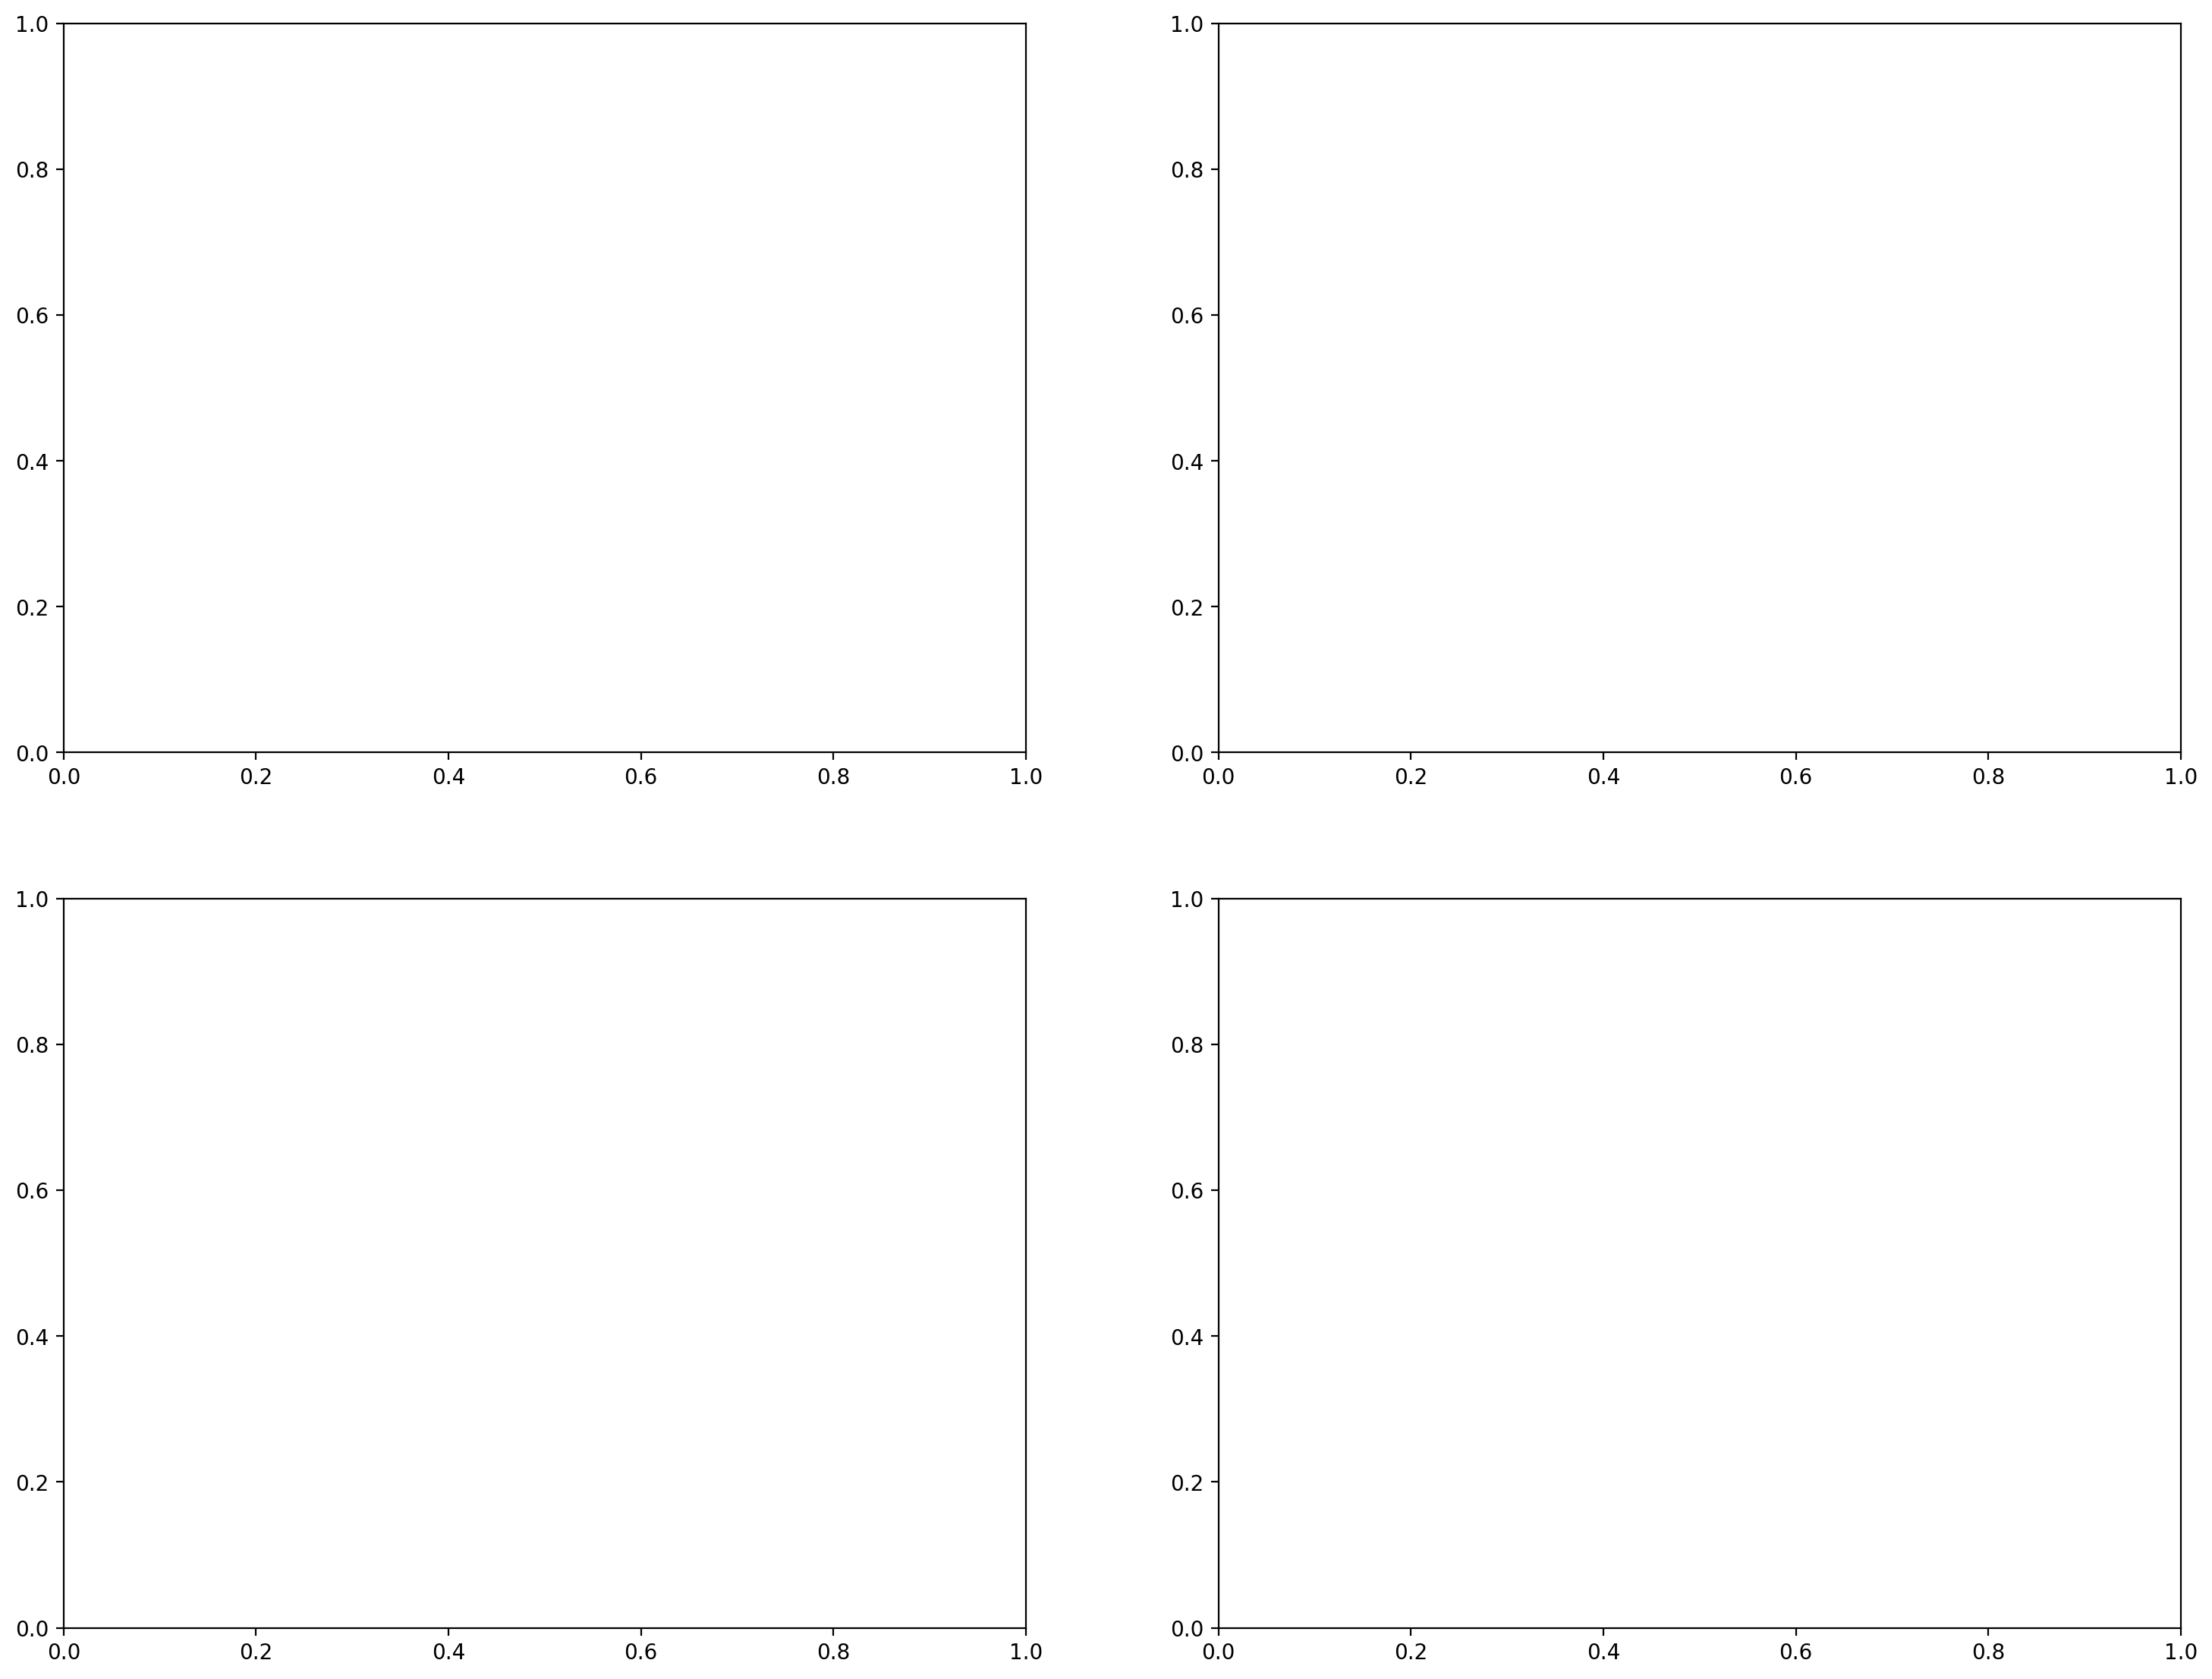

In [136]:
#set keys for extracting confusion matrices (unseen data set)
keys = ['xgbc0', 'xgbc3', 'xgbc_rcv', 'xgbc_bcv']
titles = ['Benchmark model', 'Coordinate Descent', 'Randomized Search', 'Bayesian Search']

f, axes = plt.subplots(2,2,figsize=(18,14));

for i,ax in enumerate(axes.flatten()):
    
    #computing variables for specific confusion matrix
    group_counts = ["{0:0.0f}".format(value) for value in results_dict[keys[i]]['test roc auc score'].flatten()]
    # group_percentages = ["{0:.2%}".format(value) for value in results_dict[keys[i]]['test roc auc score'].flatten()/np.sum(results_dict[keys['test roc auc score']])]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(1,-1)
    
    #plotting confusion matrix
    sns.heatmap(results_dict[keys[i]]['test roc auc score'], annot=labels, fmt='', cmap='Blues', ax=ax)
    ax.set_title(f"Confusion matrix for {titles[i]}")

### https://www.kaggle.com/prashant111/a-guide-on-xgboost-hyperparameters-tuning


In [166]:
space={ 'max_depth': hp.choice('max_depth', [5,6,7,8,9,10,11,12,13,14]),
        'gamma': hp.choice('gamma', [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200]),
        'reg_alpha' : hp.choice('reg_alpha', [0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]),
        'reg_lambda' : hp.choice('reg_lambda', [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.choice('n_estimators', [50,65,80,100,115,130,150]),
        'learning_rate': hp.choice('learning_rate', [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7]),
        'seed': 0
    }


In [170]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], 
                    max_depth =space['max_depth'], 
                    learning_Rate = space['learning_rate'],
                    gamma = space['gamma'],
                    reg_alpha = space['reg_alpha'],
                    reg_lambda = space['reg_lambda'],
                    min_child_weight=space['min_child_weight'],
                    colsample_bytree=space['colsample_bytree'])
    
    #BayesSearchCV(estimator=xgbc, search_spaces=param_grid, n_iter=bcvj, scoring='accuracy', cv=5, return_train_score=True, verbose=3)
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=30,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

In [174]:
params = deepcopy(default_params)

#setting grid of selected parameters for iteration
param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4],
              'learning_rate': [0.1, 0.15, 0.17, 0.2, 0.23, 0.25, 0.28, 0.3, 0.33],
              'max_depth': [3, 4, 5, 6],
              'n_estimators': [110, 115, 120, 125, 130, 135, 140],
              'reg_alpha': [0.1, 0.12, 0.15, 0.18, 0.2, 0.22, 0.25, 0.3],
              'reg_lambda': [0.4, 0.6, 0.8, 0.9, 1, 1.2]}

In [187]:
#start time
t0 = time.time()

#No. of jobs
bcvj = int(gcvj)

#unwrapping list values of default parameters
default_params_xgb = {}

for key in default_params.keys():
    default_params_xgb[key] = default_params[key][0]

#providing default parameters to xgbc model, before randomized search cross-validation
xgbc = xgb.XGBClassifier(**default_params_xgb)

clf = BayesSearchCV(estimator=xgbc, search_spaces=param_grid, n_iter=bcvj, scoring='accuracy', cv=3, return_train_score=True, verbose=3)
clf.fit(X_train, y_train.values.ravel())

#results dataframe
df = pd.DataFrame(clf.cv_results_)
    
#predictions - inputs to confusion matrix
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)
    
#confusion matrices
cfm_train = confusion_matrix(y_train, train_predictions)
cfm_test = confusion_matrix(y_test, test_predictions)
    
#accuracy scores
accs_train = accuracy_score(y_train, train_predictions)
accs_test = accuracy_score(y_test, test_predictions)
    
#F1 scores for each train/test label
f1s_train_p1 = f1_score(y_train, train_predictions, pos_label=1)
f1s_train_p0 = f1_score(y_train, train_predictions, pos_label=0)
f1s_test_p1 = f1_score(y_test, test_predictions, pos_label=1)
f1s_test_p0 = f1_score(y_test, test_predictions, pos_label=0)
    
#Area Under the Receiver Operating Characteristic Curve
test_ras = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
    
#best parameters
bp = clf.best_params_
    
#storing computed values in results dictionary
results_dict['xgbc_bcv'] = {'classifier': deepcopy(clf),
                            'cv_results': df.copy(),
                            'cfm_train': cfm_train,
                            'cfm_test': cfm_test,
                            'train_accuracy': accs_train,
                            'test_accuracy': accs_test,
                            'train F1-score label 1': f1s_train_p1,
                            'train F1-score label 0': f1s_train_p0,
                            'test F1-score label 1': f1s_test_p1,
                            'test F1-score label 0': f1s_test_p0,
                            'test roc auc score': test_ras,
                            'best_params': bp}

#stop time
t1 = time.time()

#elapsed time
bcvt = t1 - t0

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.4, learning_rate=0.5, max_depth=5, n_estimators=80, reg_alpha=3.2, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.4, learning_rate=0.5, max_depth=5, n_estimators=80, reg_alpha=3.2, reg_lambda=3.2, score=(train=0.974, test=0.957), total=   0.3s
[CV] gamma=0.4, learning_rate=0.5, max_depth=5, n_estimators=80, reg_alpha=3.2, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.5, max_depth=5, n_estimators=80, reg_alpha=3.2, reg_lambda=3.2, score=(train=0.974, test=0.960), total=   0.3s
[CV] gamma=0.4, learning_rate=0.5, max_depth=5, n_estimators=80, reg_alpha=3.2, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.5, max_depth=5, n_estimators=80, reg_alpha=3.2, reg_lambda=3.2, score=(train=0.972, test=0.948), total=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=12.8, learning_rate=0.4, max_depth=5, n_estimators=115, reg_alpha=200.0, reg_lambda=0.8 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=12.8, learning_rate=0.4, max_depth=5, n_estimators=115, reg_alpha=200.0, reg_lambda=0.8, score=(train=0.936, test=0.930), total=   0.2s
[CV] gamma=12.8, learning_rate=0.4, max_depth=5, n_estimators=115, reg_alpha=200.0, reg_lambda=0.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  gamma=12.8, learning_rate=0.4, max_depth=5, n_estimators=115, reg_alpha=200.0, reg_lambda=0.8, score=(train=0.923, test=0.933), total=   0.2s
[CV] gamma=12.8, learning_rate=0.4, max_depth=5, n_estimators=115, reg_alpha=200.0, reg_lambda=0.8 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV]  gamma=12.8, learning_rate=0.4, max_depth=5, n_estimators=115, reg_alpha=200.0, reg_lambda=0.8, score=(train=0.944, test=0.924), total=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=25.6, learning_rate=0.6, max_depth=12, n_estimators=100, reg_alpha=0.4, reg_lambda=0.8 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=25.6, learning_rate=0.6, max_depth=12, n_estimators=100, reg_alpha=0.4, reg_lambda=0.8, score=(train=0.950, test=0.945), total=   1.0s
[CV] gamma=25.6, learning_rate=0.6, max_depth=12, n_estimators=100, reg_alpha=0.4, reg_lambda=0.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  gamma=25.6, learning_rate=0.6, max_depth=12, n_estimators=100, reg_alpha=0.4, reg_lambda=0.8, score=(train=0.943, test=0.951), total=   1.0s
[CV] gamma=25.6, learning_rate=0.6, max_depth=12, n_estimators=100, reg_alpha=0.4, reg_lambda=0.8 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s


[CV]  gamma=25.6, learning_rate=0.6, max_depth=12, n_estimators=100, reg_alpha=0.4, reg_lambda=0.8, score=(train=0.953, test=0.940), total=   0.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.0, learning_rate=0.01, max_depth=10, n_estimators=130, reg_alpha=0.2, reg_lambda=0.1 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.0, learning_rate=0.01, max_depth=10, n_estimators=130, reg_alpha=0.2, reg_lambda=0.1, score=(train=0.973, test=0.946), total=   1.2s
[CV] gamma=0.0, learning_rate=0.01, max_depth=10, n_estimators=130, reg_alpha=0.2, reg_lambda=0.1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.01, max_depth=10, n_estimators=130, reg_alpha=0.2, reg_lambda=0.1, score=(train=0.972, test=0.955), total=   1.3s
[CV] gamma=0.0, learning_rate=0.01, max_depth=10, n_estimators=130, reg_alpha=0.2, reg_lambda=0.1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.01, max_depth=10, n_estimators=130, reg_alpha=0.2, reg_lambda=0.1, score=(train=0.977, test=0.943), total=   1.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.4, learning_rate=0.2, max_depth=12, n_estimators=80, reg_alpha=0.4, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.4, learning_rate=0.2, max_depth=12, n_estimators=80, reg_alpha=0.4, reg_lambda=0.2, score=(train=0.997, test=0.952), total=   0.5s
[CV] gamma=0.4, learning_rate=0.2, max_depth=12, n_estimators=80, reg_alpha=0.4, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.2, max_depth=12, n_estimators=80, reg_alpha=0.4, reg_lambda=0.2, score=(train=0.998, test=0.961), total=   0.5s
[CV] gamma=0.4, learning_rate=0.2, max_depth=12, n_estimators=80, reg_alpha=0.4, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.2, max_depth=12, n_estimators=80, reg_alpha=0.4, reg_lambda=0.2, score=(train=0.998, test=0.949), total=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=51.2, learning_rate=0.03, max_depth=10, n_estimators=130, reg_alpha=0.0, reg_lambda=0.1 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=51.2, learning_rate=0.03, max_depth=10, n_estimators=130, reg_alpha=0.0, reg_lambda=0.1, score=(train=0.938, test=0.935), total=   1.3s
[CV] gamma=51.2, learning_rate=0.03, max_depth=10, n_estimators=130, reg_alpha=0.0, reg_lambda=0.1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV]  gamma=51.2, learning_rate=0.03, max_depth=10, n_estimators=130, reg_alpha=0.0, reg_lambda=0.1, score=(train=0.938, test=0.950), total=   1.4s
[CV] gamma=51.2, learning_rate=0.03, max_depth=10, n_estimators=130, reg_alpha=0.0, reg_lambda=0.1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s


[CV]  gamma=51.2, learning_rate=0.03, max_depth=10, n_estimators=130, reg_alpha=0.0, reg_lambda=0.1, score=(train=0.949, test=0.931), total=   1.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=102.4, learning_rate=0.4, max_depth=8, n_estimators=100, reg_alpha=12.8, reg_lambda=102.4 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=102.4, learning_rate=0.4, max_depth=8, n_estimators=100, reg_alpha=12.8, reg_lambda=102.4, score=(train=0.927, test=0.925), total=   0.3s
[CV] gamma=102.4, learning_rate=0.4, max_depth=8, n_estimators=100, reg_alpha=12.8, reg_lambda=102.4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  gamma=102.4, learning_rate=0.4, max_depth=8, n_estimators=100, reg_alpha=12.8, reg_lambda=102.4, score=(train=0.923, test=0.933), total=   0.3s
[CV] gamma=102.4, learning_rate=0.4, max_depth=8, n_estimators=100, reg_alpha=12.8, reg_lambda=102.4 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV]  gamma=102.4, learning_rate=0.4, max_depth=8, n_estimators=100, reg_alpha=12.8, reg_lambda=102.4, score=(train=0.930, test=0.918), total=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.2, learning_rate=0.1, max_depth=6, n_estimators=65, reg_alpha=200.0, reg_lambda=0.1 
[CV]  gamma=0.2, learning_rate=0.1, max_depth=6, n_estimators=65, reg_alpha=200.0, reg_lambda=0.1, score=(train=0.942, test=0.936), total=   0.1s
[CV] gamma=0.2, learning_rate=0.1, max_depth=6, n_estimators=65, reg_alpha=200.0, reg_lambda=0.1 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  gamma=0.2, learning_rate=0.1, max_depth=6, n_estimators=65, reg_alpha=200.0, reg_lambda=0.1, score=(train=0.934, test=0.948), total=   0.1s
[CV] gamma=0.2, learning_rate=0.1, max_depth=6, n_estimators=65, reg_alpha=200.0, reg_lambda=0.1 
[CV]  gamma=0.2, learning_rate=0.1, max_depth=6, n_estimators=65, reg_alpha=200.0, reg_lambda=0.1, score=(train=0.946, test=0.927), total=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=51.2, learning_rate=0.2, max_depth=7, n_estimators=150, reg_alpha=0.1, reg_lambda=1.6 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=51.2, learning_rate=0.2, max_depth=7, n_estimators=150, reg_alpha=0.1, reg_lambda=1.6, score=(train=0.941, test=0.938), total=   0.9s
[CV] gamma=51.2, learning_rate=0.2, max_depth=7, n_estimators=150, reg_alpha=0.1, reg_lambda=1.6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  gamma=51.2, learning_rate=0.2, max_depth=7, n_estimators=150, reg_alpha=0.1, reg_lambda=1.6, score=(train=0.937, test=0.951), total=   0.8s
[CV] gamma=51.2, learning_rate=0.2, max_depth=7, n_estimators=150, reg_alpha=0.1, reg_lambda=1.6 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  gamma=51.2, learning_rate=0.2, max_depth=7, n_estimators=150, reg_alpha=0.1, reg_lambda=1.6, score=(train=0.950, test=0.932), total=   0.7s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=51.2, learning_rate=0.5, max_depth=11, n_estimators=65, reg_alpha=0.4, reg_lambda=0.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=51.2, learning_rate=0.5, max_depth=11, n_estimators=65, reg_alpha=0.4, reg_lambda=0.0, score=(train=0.941, test=0.939), total=   0.7s
[CV] gamma=51.2, learning_rate=0.5, max_depth=11, n_estimators=65, reg_alpha=0.4, reg_lambda=0.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  gamma=51.2, learning_rate=0.5, max_depth=11, n_estimators=65, reg_alpha=0.4, reg_lambda=0.0, score=(train=0.940, test=0.950), total=   0.7s
[CV] gamma=51.2, learning_rate=0.5, max_depth=11, n_estimators=65, reg_alpha=0.4, reg_lambda=0.0 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV]  gamma=51.2, learning_rate=0.5, max_depth=11, n_estimators=65, reg_alpha=0.4, reg_lambda=0.0, score=(train=0.950, test=0.932), total=   0.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=200.0, learning_rate=0.5, max_depth=11, n_estimators=80, reg_alpha=1.6, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=200.0, learning_rate=0.5, max_depth=11, n_estimators=80, reg_alpha=1.6, reg_lambda=3.2, score=(train=0.925, test=0.919), total=   0.6s
[CV] gamma=200.0, learning_rate=0.5, max_depth=11, n_estimators=80, reg_alpha=1.6, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  gamma=200.0, learning_rate=0.5, max_depth=11, n_estimators=80, reg_alpha=1.6, reg_lambda=3.2, score=(train=0.924, test=0.932), total=   0.6s
[CV] gamma=200.0, learning_rate=0.5, max_depth=11, n_estimators=80, reg_alpha=1.6, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  gamma=200.0, learning_rate=0.5, max_depth=11, n_estimators=80, reg_alpha=1.6, reg_lambda=3.2, score=(train=0.928, test=0.917), total=   0.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.8, learning_rate=0.6, max_depth=12, n_estimators=65, reg_alpha=0.4, reg_lambda=0.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.8, learning_rate=0.6, max_depth=12, n_estimators=65, reg_alpha=0.4, reg_lambda=0.0, score=(train=0.996, test=0.950), total=   0.4s
[CV] gamma=0.8, learning_rate=0.6, max_depth=12, n_estimators=65, reg_alpha=0.4, reg_lambda=0.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.6, max_depth=12, n_estimators=65, reg_alpha=0.4, reg_lambda=0.0, score=(train=0.998, test=0.957), total=   0.4s
[CV] gamma=0.8, learning_rate=0.6, max_depth=12, n_estimators=65, reg_alpha=0.4, reg_lambda=0.0 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.6, max_depth=12, n_estimators=65, reg_alpha=0.4, reg_lambda=0.0, score=(train=0.996, test=0.945), total=   0.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=1.6, learning_rate=0.2, max_depth=12, n_estimators=65, reg_alpha=0.4, reg_lambda=0.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=1.6, learning_rate=0.2, max_depth=12, n_estimators=65, reg_alpha=0.4, reg_lambda=0.0, score=(train=0.990, test=0.953), total=   0.5s
[CV] gamma=1.6, learning_rate=0.2, max_depth=12, n_estimators=65, reg_alpha=0.4, reg_lambda=0.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  gamma=1.6, learning_rate=0.2, max_depth=12, n_estimators=65, reg_alpha=0.4, reg_lambda=0.0, score=(train=0.989, test=0.958), total=   0.5s
[CV] gamma=1.6, learning_rate=0.2, max_depth=12, n_estimators=65, reg_alpha=0.4, reg_lambda=0.0 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV]  gamma=1.6, learning_rate=0.2, max_depth=12, n_estimators=65, reg_alpha=0.4, reg_lambda=0.0, score=(train=0.989, test=0.949), total=   0.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.4, learning_rate=0.2, max_depth=12, n_estimators=65, reg_alpha=3.2, reg_lambda=0.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.4, learning_rate=0.2, max_depth=12, n_estimators=65, reg_alpha=3.2, reg_lambda=0.0, score=(train=0.982, test=0.952), total=   0.4s
[CV] gamma=0.4, learning_rate=0.2, max_depth=12, n_estimators=65, reg_alpha=3.2, reg_lambda=0.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.2, max_depth=12, n_estimators=65, reg_alpha=3.2, reg_lambda=0.0, score=(train=0.979, test=0.963), total=   0.4s
[CV] gamma=0.4, learning_rate=0.2, max_depth=12, n_estimators=65, reg_alpha=3.2, reg_lambda=0.0 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.2, max_depth=12, n_estimators=65, reg_alpha=3.2, reg_lambda=0.0, score=(train=0.980, test=0.948), total=   0.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=1.6, learning_rate=0.300000012, max_depth=6, n_estimators=130, reg_alpha=3.2, reg_lambda=12.8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=1.6, learning_rate=0.300000012, max_depth=6, n_estimators=130, reg_alpha=3.2, reg_lambda=12.8, score=(train=0.965, test=0.955), total=   0.6s
[CV] gamma=1.6, learning_rate=0.300000012, max_depth=6, n_estimators=130, reg_alpha=3.2, reg_lambda=12.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  gamma=1.6, learning_rate=0.300000012, max_depth=6, n_estimators=130, reg_alpha=3.2, reg_lambda=12.8, score=(train=0.962, test=0.960), total=   0.6s
[CV] gamma=1.6, learning_rate=0.300000012, max_depth=6, n_estimators=130, reg_alpha=3.2, reg_lambda=12.8 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  gamma=1.6, learning_rate=0.300000012, max_depth=6, n_estimators=130, reg_alpha=3.2, reg_lambda=12.8, score=(train=0.966, test=0.945), total=   0.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=1.6, learning_rate=0.2, max_depth=12, n_estimators=80, reg_alpha=0.8, reg_lambda=25.6 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=1.6, learning_rate=0.2, max_depth=12, n_estimators=80, reg_alpha=0.8, reg_lambda=25.6, score=(train=0.966, test=0.952), total=   0.6s
[CV] gamma=1.6, learning_rate=0.2, max_depth=12, n_estimators=80, reg_alpha=0.8, reg_lambda=25.6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  gamma=1.6, learning_rate=0.2, max_depth=12, n_estimators=80, reg_alpha=0.8, reg_lambda=25.6, score=(train=0.962, test=0.961), total=   0.6s
[CV] gamma=1.6, learning_rate=0.2, max_depth=12, n_estimators=80, reg_alpha=0.8, reg_lambda=25.6 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  gamma=1.6, learning_rate=0.2, max_depth=12, n_estimators=80, reg_alpha=0.8, reg_lambda=25.6, score=(train=0.965, test=0.946), total=   0.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=6.4, learning_rate=0.25, max_depth=12, n_estimators=65, reg_alpha=3.2, reg_lambda=0.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=6.4, learning_rate=0.25, max_depth=12, n_estimators=65, reg_alpha=3.2, reg_lambda=0.0, score=(train=0.958, test=0.949), total=   0.5s
[CV] gamma=6.4, learning_rate=0.25, max_depth=12, n_estimators=65, reg_alpha=3.2, reg_lambda=0.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  gamma=6.4, learning_rate=0.25, max_depth=12, n_estimators=65, reg_alpha=3.2, reg_lambda=0.0, score=(train=0.958, test=0.959), total=   0.5s
[CV] gamma=6.4, learning_rate=0.25, max_depth=12, n_estimators=65, reg_alpha=3.2, reg_lambda=0.0 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV]  gamma=6.4, learning_rate=0.25, max_depth=12, n_estimators=65, reg_alpha=3.2, reg_lambda=0.0, score=(train=0.960, test=0.943), total=   0.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.4, learning_rate=0.2, max_depth=12, n_estimators=80, reg_alpha=6.4, reg_lambda=0.1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.4, learning_rate=0.2, max_depth=12, n_estimators=80, reg_alpha=6.4, reg_lambda=0.1, score=(train=0.969, test=0.952), total=   0.4s
[CV] gamma=0.4, learning_rate=0.2, max_depth=12, n_estimators=80, reg_alpha=6.4, reg_lambda=0.1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.2, max_depth=12, n_estimators=80, reg_alpha=6.4, reg_lambda=0.1, score=(train=0.967, test=0.961), total=   0.3s
[CV] gamma=0.4, learning_rate=0.2, max_depth=12, n_estimators=80, reg_alpha=6.4, reg_lambda=0.1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.2, max_depth=12, n_estimators=80, reg_alpha=6.4, reg_lambda=0.1, score=(train=0.971, test=0.946), total=   0.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=3.2, learning_rate=0.01, max_depth=12, n_estimators=65, reg_alpha=0.4, reg_lambda=0.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=3.2, learning_rate=0.01, max_depth=12, n_estimators=65, reg_alpha=0.4, reg_lambda=0.0, score=(train=0.965, test=0.948), total=   0.6s
[CV] gamma=3.2, learning_rate=0.01, max_depth=12, n_estimators=65, reg_alpha=0.4, reg_lambda=0.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  gamma=3.2, learning_rate=0.01, max_depth=12, n_estimators=65, reg_alpha=0.4, reg_lambda=0.0, score=(train=0.961, test=0.955), total=   0.6s
[CV] gamma=3.2, learning_rate=0.01, max_depth=12, n_estimators=65, reg_alpha=0.4, reg_lambda=0.0 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV]  gamma=3.2, learning_rate=0.01, max_depth=12, n_estimators=65, reg_alpha=0.4, reg_lambda=0.0, score=(train=0.968, test=0.941), total=   0.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.4, learning_rate=0.2, max_depth=12, n_estimators=80, reg_alpha=51.2, reg_lambda=0.4 
[CV]  gamma=0.4, learning_rate=0.2, max_depth=12, n_estimators=80, reg_alpha=51.2, reg_lambda=0.4, score=(train=0.949, test=0.942), total=   0.2s
[CV] gamma=0.4, learning_rate=0.2, max_depth=12, n_estimators=80, reg_alpha=51.2, reg_lambda=0.4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.2, max_depth=12, n_estimators=80, reg_alpha=51.2, reg_lambda=0.4, score=(train=0.944, test=0.952), total=   0.1s
[CV] gamma=0.4, learning_rate=0.2, max_depth=12, n_estimators=80, reg_alpha=51.2, reg_lambda=0.4 
[CV]  gamma=0.4, learning_rate=0.2, max_depth=12, n_estimators=80, reg_alpha=51.2, reg_lambda=0.4, score=(train=0.952, test=0.932), total=   0.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.4, learning_rate=0.2, max_depth=12, n_estimators=80, reg_alpha=102.4, reg_lambda=12.8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.4, learning_rate=0.2, max_depth=12, n_estimators=80, reg_alpha=102.4, reg_lambda=12.8, score=(train=0.944, test=0.939), total=   0.2s
[CV] gamma=0.4, learning_rate=0.2, max_depth=12, n_estimators=80, reg_alpha=102.4, reg_lambda=12.8 
[CV]  gamma=0.4, learning_rate=0.2, max_depth=12, n_estimators=80, reg_alpha=102.4, reg_lambda=12.8, score=(train=0.939, test=0.949), total=   0.2s
[CV] gamma=0.4, learning_rate=0.2, max_depth=12, n_estimators=80, reg_alpha=102.4, reg_lambda=12.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.2, max_depth=12, n_estimators=80, reg_alpha=102.4, reg_lambda=12.8, score=(train=0.947, test=0.931), total=   0.1s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.4, learning_rate=0.7, max_depth=12, n_estimators=130, reg_alpha=25.6, reg_lambda=0.1 
[CV]  gamma=0.4, learning_rate=0.7, max_depth=12, n_estimators=130, reg_alpha=25.6, reg_lambda=0.1, score=(train=0.958, test=0.950), total=   0.1s
[CV] gamma=0.4, learning_rate=0.7, max_depth=12, n_estimators=130, reg_alpha=25.6, reg_lambda=0.1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.7, max_depth=12, n_estimators=130, reg_alpha=25.6, reg_lambda=0.1, score=(train=0.950, test=0.954), total=   0.1s
[CV] gamma=0.4, learning_rate=0.7, max_depth=12, n_estimators=130, reg_alpha=25.6, reg_lambda=0.1 
[CV]  gamma=0.4, learning_rate=0.7, max_depth=12, n_estimators=130, reg_alpha=25.6, reg_lambda=0.1, score=(train=0.958, test=0.935), total=   0.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.4, learning_rate=0.2, max_depth=6, n_estimators=65, reg_alpha=0.8, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.4, learning_rate=0.2, max_depth=6, n_estimators=65, reg_alpha=0.8, reg_lambda=3.2, score=(train=0.981, test=0.954), total=   0.3s
[CV] gamma=0.4, learning_rate=0.2, max_depth=6, n_estimators=65, reg_alpha=0.8, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.2, max_depth=6, n_estimators=65, reg_alpha=0.8, reg_lambda=3.2, score=(train=0.980, test=0.959), total=   0.3s
[CV] gamma=0.4, learning_rate=0.2, max_depth=6, n_estimators=65, reg_alpha=0.8, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.2, max_depth=6, n_estimators=65, reg_alpha=0.8, reg_lambda=3.2, score=(train=0.980, test=0.949), total=   0.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.4, learning_rate=0.1, max_depth=14, n_estimators=65, reg_alpha=0.2, reg_lambda=51.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.4, learning_rate=0.1, max_depth=14, n_estimators=65, reg_alpha=0.2, reg_lambda=51.2, score=(train=0.964, test=0.952), total=   0.4s
[CV] gamma=0.4, learning_rate=0.1, max_depth=14, n_estimators=65, reg_alpha=0.2, reg_lambda=51.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.1, max_depth=14, n_estimators=65, reg_alpha=0.2, reg_lambda=51.2, score=(train=0.960, test=0.960), total=   0.4s
[CV] gamma=0.4, learning_rate=0.1, max_depth=14, n_estimators=65, reg_alpha=0.2, reg_lambda=51.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.1, max_depth=14, n_estimators=65, reg_alpha=0.2, reg_lambda=51.2, score=(train=0.965, test=0.946), total=   0.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.1, learning_rate=0.2, max_depth=9, n_estimators=50, reg_alpha=3.2, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.1, learning_rate=0.2, max_depth=9, n_estimators=50, reg_alpha=3.2, reg_lambda=0.2, score=(train=0.981, test=0.955), total=   0.3s
[CV] gamma=0.1, learning_rate=0.2, max_depth=9, n_estimators=50, reg_alpha=3.2, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.2, max_depth=9, n_estimators=50, reg_alpha=3.2, reg_lambda=0.2, score=(train=0.980, test=0.964), total=   0.3s
[CV] gamma=0.1, learning_rate=0.2, max_depth=9, n_estimators=50, reg_alpha=3.2, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.2, max_depth=9, n_estimators=50, reg_alpha=3.2, reg_lambda=0.2, score=(train=0.981, test=0.948), total=   0.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.2, learning_rate=0.2, max_depth=12, n_estimators=80, reg_alpha=3.2, reg_lambda=25.6 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.2, learning_rate=0.2, max_depth=12, n_estimators=80, reg_alpha=3.2, reg_lambda=25.6, score=(train=0.972, test=0.957), total=   0.5s
[CV] gamma=0.2, learning_rate=0.2, max_depth=12, n_estimators=80, reg_alpha=3.2, reg_lambda=25.6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  gamma=0.2, learning_rate=0.2, max_depth=12, n_estimators=80, reg_alpha=3.2, reg_lambda=25.6, score=(train=0.969, test=0.960), total=   0.5s
[CV] gamma=0.2, learning_rate=0.2, max_depth=12, n_estimators=80, reg_alpha=3.2, reg_lambda=25.6 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV]  gamma=0.2, learning_rate=0.2, max_depth=12, n_estimators=80, reg_alpha=3.2, reg_lambda=25.6, score=(train=0.972, test=0.947), total=   0.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.8, learning_rate=0.1, max_depth=9, n_estimators=80, reg_alpha=6.4, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.8, learning_rate=0.1, max_depth=9, n_estimators=80, reg_alpha=6.4, reg_lambda=0.2, score=(train=0.967, test=0.952), total=   0.4s
[CV] gamma=0.8, learning_rate=0.1, max_depth=9, n_estimators=80, reg_alpha=6.4, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.1, max_depth=9, n_estimators=80, reg_alpha=6.4, reg_lambda=0.2, score=(train=0.964, test=0.962), total=   0.4s
[CV] gamma=0.8, learning_rate=0.1, max_depth=9, n_estimators=80, reg_alpha=6.4, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.1, max_depth=9, n_estimators=80, reg_alpha=6.4, reg_lambda=0.2, score=(train=0.969, test=0.946), total=   0.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.0, learning_rate=0.1, max_depth=13, n_estimators=115, reg_alpha=3.2, reg_lambda=6.4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.0, learning_rate=0.1, max_depth=13, n_estimators=115, reg_alpha=3.2, reg_lambda=6.4, score=(train=0.978, test=0.954), total=   0.7s
[CV] gamma=0.0, learning_rate=0.1, max_depth=13, n_estimators=115, reg_alpha=3.2, reg_lambda=6.4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.1, max_depth=13, n_estimators=115, reg_alpha=3.2, reg_lambda=6.4, score=(train=0.977, test=0.962), total=   0.7s
[CV] gamma=0.0, learning_rate=0.1, max_depth=13, n_estimators=115, reg_alpha=3.2, reg_lambda=6.4 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.1, max_depth=13, n_estimators=115, reg_alpha=3.2, reg_lambda=6.4, score=(train=0.977, test=0.947), total=   0.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.4, learning_rate=0.06, max_depth=8, n_estimators=80, reg_alpha=0.8, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.4, learning_rate=0.06, max_depth=8, n_estimators=80, reg_alpha=0.8, reg_lambda=0.2, score=(train=0.980, test=0.955), total=   0.6s
[CV] gamma=0.4, learning_rate=0.06, max_depth=8, n_estimators=80, reg_alpha=0.8, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.06, max_depth=8, n_estimators=80, reg_alpha=0.8, reg_lambda=0.2, score=(train=0.976, test=0.958), total=   0.6s
[CV] gamma=0.4, learning_rate=0.06, max_depth=8, n_estimators=80, reg_alpha=0.8, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.06, max_depth=8, n_estimators=80, reg_alpha=0.8, reg_lambda=0.2, score=(train=0.981, test=0.948), total=   0.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.2, learning_rate=0.7, max_depth=6, n_estimators=50, reg_alpha=6.4, reg_lambda=12.8 
[CV]  gamma=0.2, learning_rate=0.7, max_depth=6, n_estimators=50, reg_alpha=6.4, reg_lambda=12.8, score=(train=0.967, test=0.952), total=   0.1s
[CV] gamma=0.2, learning_rate=0.7, max_depth=6, n_estimators=50, reg_alpha=6.4, reg_lambda=12.8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  gamma=0.2, learning_rate=0.7, max_depth=6, n_estimators=50, reg_alpha=6.4, reg_lambda=12.8, score=(train=0.966, test=0.961), total=   0.1s
[CV] gamma=0.2, learning_rate=0.7, max_depth=6, n_estimators=50, reg_alpha=6.4, reg_lambda=12.8 
[CV]  gamma=0.2, learning_rate=0.7, max_depth=6, n_estimators=50, reg_alpha=6.4, reg_lambda=12.8, score=(train=0.969, test=0.948), total=   0.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.4, learning_rate=0.1, max_depth=7, n_estimators=150, reg_alpha=3.2, reg_lambda=0.1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.4, learning_rate=0.1, max_depth=7, n_estimators=150, reg_alpha=3.2, reg_lambda=0.1, score=(train=0.978, test=0.952), total=   0.7s
[CV] gamma=0.4, learning_rate=0.1, max_depth=7, n_estimators=150, reg_alpha=3.2, reg_lambda=0.1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.1, max_depth=7, n_estimators=150, reg_alpha=3.2, reg_lambda=0.1, score=(train=0.976, test=0.962), total=   0.7s
[CV] gamma=0.4, learning_rate=0.1, max_depth=7, n_estimators=150, reg_alpha=3.2, reg_lambda=0.1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV]  gamma=0.4, learning_rate=0.1, max_depth=7, n_estimators=150, reg_alpha=3.2, reg_lambda=0.1, score=(train=0.977, test=0.947), total=   0.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.1, learning_rate=0.1, max_depth=12, n_estimators=130, reg_alpha=0.8, reg_lambda=0.4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.1, learning_rate=0.1, max_depth=12, n_estimators=130, reg_alpha=0.8, reg_lambda=0.4, score=(train=0.997, test=0.953), total=   0.9s
[CV] gamma=0.1, learning_rate=0.1, max_depth=12, n_estimators=130, reg_alpha=0.8, reg_lambda=0.4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.1, max_depth=12, n_estimators=130, reg_alpha=0.8, reg_lambda=0.4, score=(train=0.998, test=0.960), total=   0.9s
[CV] gamma=0.1, learning_rate=0.1, max_depth=12, n_estimators=130, reg_alpha=0.8, reg_lambda=0.4 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.1, max_depth=12, n_estimators=130, reg_alpha=0.8, reg_lambda=0.4, score=(train=0.998, test=0.948), total=   0.8s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.1, learning_rate=0.15, max_depth=8, n_estimators=150, reg_alpha=6.4, reg_lambda=1.6 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.1, learning_rate=0.15, max_depth=8, n_estimators=150, reg_alpha=6.4, reg_lambda=1.6, score=(train=0.971, test=0.952), total=   0.4s
[CV] gamma=0.1, learning_rate=0.15, max_depth=8, n_estimators=150, reg_alpha=6.4, reg_lambda=1.6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.15, max_depth=8, n_estimators=150, reg_alpha=6.4, reg_lambda=1.6, score=(train=0.968, test=0.963), total=   0.3s
[CV] gamma=0.1, learning_rate=0.15, max_depth=8, n_estimators=150, reg_alpha=6.4, reg_lambda=1.6 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.15, max_depth=8, n_estimators=150, reg_alpha=6.4, reg_lambda=1.6, score=(train=0.971, test=0.947), total=   0.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.2, learning_rate=0.1, max_depth=14, n_estimators=65, reg_alpha=3.2, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.2, learning_rate=0.1, max_depth=14, n_estimators=65, reg_alpha=3.2, reg_lambda=0.2, score=(train=0.977, test=0.956), total=   0.5s
[CV] gamma=0.2, learning_rate=0.1, max_depth=14, n_estimators=65, reg_alpha=3.2, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  gamma=0.2, learning_rate=0.1, max_depth=14, n_estimators=65, reg_alpha=3.2, reg_lambda=0.2, score=(train=0.974, test=0.961), total=   0.4s
[CV] gamma=0.2, learning_rate=0.1, max_depth=14, n_estimators=65, reg_alpha=3.2, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV]  gamma=0.2, learning_rate=0.1, max_depth=14, n_estimators=65, reg_alpha=3.2, reg_lambda=0.2, score=(train=0.976, test=0.947), total=   0.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.8, learning_rate=0.2, max_depth=13, n_estimators=65, reg_alpha=3.2, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.8, learning_rate=0.2, max_depth=13, n_estimators=65, reg_alpha=3.2, reg_lambda=0.2, score=(train=0.977, test=0.955), total=   0.4s
[CV] gamma=0.8, learning_rate=0.2, max_depth=13, n_estimators=65, reg_alpha=3.2, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.2, max_depth=13, n_estimators=65, reg_alpha=3.2, reg_lambda=0.2, score=(train=0.972, test=0.962), total=   0.4s
[CV] gamma=0.8, learning_rate=0.2, max_depth=13, n_estimators=65, reg_alpha=3.2, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.2, max_depth=13, n_estimators=65, reg_alpha=3.2, reg_lambda=0.2, score=(train=0.975, test=0.948), total=   0.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.0, learning_rate=0.2, max_depth=14, n_estimators=50, reg_alpha=25.6, reg_lambda=12.8 
[CV]  gamma=0.0, learning_rate=0.2, max_depth=14, n_estimators=50, reg_alpha=25.6, reg_lambda=12.8, score=(train=0.958, test=0.950), total=   0.2s
[CV] gamma=0.0, learning_rate=0.2, max_depth=14, n_estimators=50, reg_alpha=25.6, reg_lambda=12.8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.2, max_depth=14, n_estimators=50, reg_alpha=25.6, reg_lambda=12.8, score=(train=0.954, test=0.955), total=   0.1s
[CV] gamma=0.0, learning_rate=0.2, max_depth=14, n_estimators=50, reg_alpha=25.6, reg_lambda=12.8 
[CV]  gamma=0.0, learning_rate=0.2, max_depth=14, n_estimators=50, reg_alpha=25.6, reg_lambda=12.8, score=(train=0.959, test=0.941), total=   0.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.8, learning_rate=0.15, max_depth=6, n_estimators=80, reg_alpha=0.2, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.8, learning_rate=0.15, max_depth=6, n_estimators=80, reg_alpha=0.2, reg_lambda=3.2, score=(train=0.979, test=0.956), total=   0.4s
[CV] gamma=0.8, learning_rate=0.15, max_depth=6, n_estimators=80, reg_alpha=0.2, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.15, max_depth=6, n_estimators=80, reg_alpha=0.2, reg_lambda=3.2, score=(train=0.979, test=0.962), total=   0.4s
[CV] gamma=0.8, learning_rate=0.15, max_depth=6, n_estimators=80, reg_alpha=0.2, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.15, max_depth=6, n_estimators=80, reg_alpha=0.2, reg_lambda=3.2, score=(train=0.978, test=0.948), total=   0.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.2, learning_rate=0.15, max_depth=9, n_estimators=50, reg_alpha=0.8, reg_lambda=1.6 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.2, learning_rate=0.15, max_depth=9, n_estimators=50, reg_alpha=0.8, reg_lambda=1.6, score=(train=0.986, test=0.953), total=   0.4s
[CV] gamma=0.2, learning_rate=0.15, max_depth=9, n_estimators=50, reg_alpha=0.8, reg_lambda=1.6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  gamma=0.2, learning_rate=0.15, max_depth=9, n_estimators=50, reg_alpha=0.8, reg_lambda=1.6, score=(train=0.984, test=0.961), total=   0.4s
[CV] gamma=0.2, learning_rate=0.15, max_depth=9, n_estimators=50, reg_alpha=0.8, reg_lambda=1.6 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV]  gamma=0.2, learning_rate=0.15, max_depth=9, n_estimators=50, reg_alpha=0.8, reg_lambda=1.6, score=(train=0.984, test=0.948), total=   0.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.2, learning_rate=0.03, max_depth=9, n_estimators=50, reg_alpha=0.2, reg_lambda=12.8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.2, learning_rate=0.03, max_depth=9, n_estimators=50, reg_alpha=0.2, reg_lambda=12.8, score=(train=0.962, test=0.949), total=   0.3s
[CV] gamma=0.2, learning_rate=0.03, max_depth=9, n_estimators=50, reg_alpha=0.2, reg_lambda=12.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  gamma=0.2, learning_rate=0.03, max_depth=9, n_estimators=50, reg_alpha=0.2, reg_lambda=12.8, score=(train=0.957, test=0.958), total=   0.3s
[CV] gamma=0.2, learning_rate=0.03, max_depth=9, n_estimators=50, reg_alpha=0.2, reg_lambda=12.8 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV]  gamma=0.2, learning_rate=0.03, max_depth=9, n_estimators=50, reg_alpha=0.2, reg_lambda=12.8, score=(train=0.962, test=0.936), total=   0.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=3.2, learning_rate=0.06, max_depth=12, n_estimators=65, reg_alpha=6.4, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=3.2, learning_rate=0.06, max_depth=12, n_estimators=65, reg_alpha=6.4, reg_lambda=3.2, score=(train=0.957, test=0.949), total=   0.4s
[CV] gamma=3.2, learning_rate=0.06, max_depth=12, n_estimators=65, reg_alpha=6.4, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  gamma=3.2, learning_rate=0.06, max_depth=12, n_estimators=65, reg_alpha=6.4, reg_lambda=3.2, score=(train=0.954, test=0.958), total=   0.4s
[CV] gamma=3.2, learning_rate=0.06, max_depth=12, n_estimators=65, reg_alpha=6.4, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV]  gamma=3.2, learning_rate=0.06, max_depth=12, n_estimators=65, reg_alpha=6.4, reg_lambda=3.2, score=(train=0.957, test=0.939), total=   0.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=102.4, learning_rate=0.15, max_depth=6, n_estimators=80, reg_alpha=3.2, reg_lambda=51.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=102.4, learning_rate=0.15, max_depth=6, n_estimators=80, reg_alpha=3.2, reg_lambda=51.2, score=(train=0.925, test=0.917), total=   0.3s
[CV] gamma=102.4, learning_rate=0.15, max_depth=6, n_estimators=80, reg_alpha=3.2, reg_lambda=51.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  gamma=102.4, learning_rate=0.15, max_depth=6, n_estimators=80, reg_alpha=3.2, reg_lambda=51.2, score=(train=0.923, test=0.933), total=   0.3s
[CV] gamma=102.4, learning_rate=0.15, max_depth=6, n_estimators=80, reg_alpha=3.2, reg_lambda=51.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV]  gamma=102.4, learning_rate=0.15, max_depth=6, n_estimators=80, reg_alpha=3.2, reg_lambda=51.2, score=(train=0.930, test=0.918), total=   0.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=80, reg_alpha=12.8, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=80, reg_alpha=12.8, reg_lambda=3.2, score=(train=0.963, test=0.954), total=   0.3s
[CV] gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=80, reg_alpha=12.8, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=80, reg_alpha=12.8, reg_lambda=3.2, score=(train=0.959, test=0.959), total=   0.3s
[CV] gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=80, reg_alpha=12.8, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=80, reg_alpha=12.8, reg_lambda=3.2, score=(train=0.965, test=0.943), total=   0.2s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.8, learning_rate=0.03, max_depth=14, n_estimators=115, reg_alpha=0.8, reg_lambda=1.6 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.8, learning_rate=0.03, max_depth=14, n_estimators=115, reg_alpha=0.8, reg_lambda=1.6, score=(train=0.973, test=0.954), total=   1.0s
[CV] gamma=0.8, learning_rate=0.03, max_depth=14, n_estimators=115, reg_alpha=0.8, reg_lambda=1.6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.03, max_depth=14, n_estimators=115, reg_alpha=0.8, reg_lambda=1.6, score=(train=0.972, test=0.960), total=   1.0s
[CV] gamma=0.8, learning_rate=0.03, max_depth=14, n_estimators=115, reg_alpha=0.8, reg_lambda=1.6 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.03, max_depth=14, n_estimators=115, reg_alpha=0.8, reg_lambda=1.6, score=(train=0.973, test=0.947), total=   0.9s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.1, learning_rate=0.25, max_depth=11, n_estimators=100, reg_alpha=0.1, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.1, learning_rate=0.25, max_depth=11, n_estimators=100, reg_alpha=0.1, reg_lambda=3.2, score=(train=0.999, test=0.953), total=   0.6s
[CV] gamma=0.1, learning_rate=0.25, max_depth=11, n_estimators=100, reg_alpha=0.1, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.25, max_depth=11, n_estimators=100, reg_alpha=0.1, reg_lambda=3.2, score=(train=1.000, test=0.960), total=   0.6s
[CV] gamma=0.1, learning_rate=0.25, max_depth=11, n_estimators=100, reg_alpha=0.1, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.25, max_depth=11, n_estimators=100, reg_alpha=0.1, reg_lambda=3.2, score=(train=1.000, test=0.949), total=   0.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.1, learning_rate=0.4, max_depth=7, n_estimators=115, reg_alpha=3.2, reg_lambda=6.4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.1, learning_rate=0.4, max_depth=7, n_estimators=115, reg_alpha=3.2, reg_lambda=6.4, score=(train=0.980, test=0.952), total=   0.3s
[CV] gamma=0.1, learning_rate=0.4, max_depth=7, n_estimators=115, reg_alpha=3.2, reg_lambda=6.4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.4, max_depth=7, n_estimators=115, reg_alpha=3.2, reg_lambda=6.4, score=(train=0.980, test=0.960), total=   0.3s
[CV] gamma=0.1, learning_rate=0.4, max_depth=7, n_estimators=115, reg_alpha=3.2, reg_lambda=6.4 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.4, max_depth=7, n_estimators=115, reg_alpha=3.2, reg_lambda=6.4, score=(train=0.979, test=0.947), total=   0.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.8, learning_rate=0.1, max_depth=8, n_estimators=100, reg_alpha=1.6, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.8, learning_rate=0.1, max_depth=8, n_estimators=100, reg_alpha=1.6, reg_lambda=3.2, score=(train=0.977, test=0.954), total=   0.9s
[CV] gamma=0.8, learning_rate=0.1, max_depth=8, n_estimators=100, reg_alpha=1.6, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.1, max_depth=8, n_estimators=100, reg_alpha=1.6, reg_lambda=3.2, score=(train=0.975, test=0.963), total=   0.6s
[CV] gamma=0.8, learning_rate=0.1, max_depth=8, n_estimators=100, reg_alpha=1.6, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.1, max_depth=8, n_estimators=100, reg_alpha=1.6, reg_lambda=3.2, score=(train=0.975, test=0.948), total=   0.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.8, learning_rate=0.2, max_depth=8, n_estimators=50, reg_alpha=0.0, reg_lambda=1.6 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.8, learning_rate=0.2, max_depth=8, n_estimators=50, reg_alpha=0.0, reg_lambda=1.6, score=(train=0.988, test=0.954), total=   0.3s
[CV] gamma=0.8, learning_rate=0.2, max_depth=8, n_estimators=50, reg_alpha=0.0, reg_lambda=1.6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.2, max_depth=8, n_estimators=50, reg_alpha=0.0, reg_lambda=1.6, score=(train=0.987, test=0.961), total=   0.3s
[CV] gamma=0.8, learning_rate=0.2, max_depth=8, n_estimators=50, reg_alpha=0.0, reg_lambda=1.6 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.2, max_depth=8, n_estimators=50, reg_alpha=0.0, reg_lambda=1.6, score=(train=0.987, test=0.949), total=   0.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.8, learning_rate=0.15, max_depth=8, n_estimators=150, reg_alpha=0.1, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.8, learning_rate=0.15, max_depth=8, n_estimators=150, reg_alpha=0.1, reg_lambda=3.2, score=(train=0.989, test=0.950), total=   0.8s
[CV] gamma=0.8, learning_rate=0.15, max_depth=8, n_estimators=150, reg_alpha=0.1, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.15, max_depth=8, n_estimators=150, reg_alpha=0.1, reg_lambda=3.2, score=(train=0.985, test=0.961), total=   0.8s
[CV] gamma=0.8, learning_rate=0.15, max_depth=8, n_estimators=150, reg_alpha=0.1, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.15, max_depth=8, n_estimators=150, reg_alpha=0.1, reg_lambda=3.2, score=(train=0.984, test=0.946), total=   0.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=6.4, learning_rate=0.2, max_depth=6, n_estimators=115, reg_alpha=1.6, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=6.4, learning_rate=0.2, max_depth=6, n_estimators=115, reg_alpha=1.6, reg_lambda=0.2, score=(train=0.962, test=0.951), total=   0.5s
[CV] gamma=6.4, learning_rate=0.2, max_depth=6, n_estimators=115, reg_alpha=1.6, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  gamma=6.4, learning_rate=0.2, max_depth=6, n_estimators=115, reg_alpha=1.6, reg_lambda=0.2, score=(train=0.959, test=0.961), total=   0.5s
[CV] gamma=6.4, learning_rate=0.2, max_depth=6, n_estimators=115, reg_alpha=1.6, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV]  gamma=6.4, learning_rate=0.2, max_depth=6, n_estimators=115, reg_alpha=1.6, reg_lambda=0.2, score=(train=0.962, test=0.945), total=   0.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=1.6, learning_rate=0.15, max_depth=13, n_estimators=50, reg_alpha=1.6, reg_lambda=0.8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=1.6, learning_rate=0.15, max_depth=13, n_estimators=50, reg_alpha=1.6, reg_lambda=0.8, score=(train=0.975, test=0.956), total=   0.4s
[CV] gamma=1.6, learning_rate=0.15, max_depth=13, n_estimators=50, reg_alpha=1.6, reg_lambda=0.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  gamma=1.6, learning_rate=0.15, max_depth=13, n_estimators=50, reg_alpha=1.6, reg_lambda=0.8, score=(train=0.973, test=0.959), total=   0.5s
[CV] gamma=1.6, learning_rate=0.15, max_depth=13, n_estimators=50, reg_alpha=1.6, reg_lambda=0.8 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV]  gamma=1.6, learning_rate=0.15, max_depth=13, n_estimators=50, reg_alpha=1.6, reg_lambda=0.8, score=(train=0.975, test=0.949), total=   0.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=1.6, learning_rate=0.15, max_depth=11, n_estimators=50, reg_alpha=12.8, reg_lambda=6.4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=1.6, learning_rate=0.15, max_depth=11, n_estimators=50, reg_alpha=12.8, reg_lambda=6.4, score=(train=0.959, test=0.951), total=   0.2s
[CV] gamma=1.6, learning_rate=0.15, max_depth=11, n_estimators=50, reg_alpha=12.8, reg_lambda=6.4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  gamma=1.6, learning_rate=0.15, max_depth=11, n_estimators=50, reg_alpha=12.8, reg_lambda=6.4, score=(train=0.955, test=0.958), total=   0.2s
[CV] gamma=1.6, learning_rate=0.15, max_depth=11, n_estimators=50, reg_alpha=12.8, reg_lambda=6.4 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV]  gamma=1.6, learning_rate=0.15, max_depth=11, n_estimators=50, reg_alpha=12.8, reg_lambda=6.4, score=(train=0.958, test=0.939), total=   0.2s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.0, learning_rate=0.300000012, max_depth=14, n_estimators=65, reg_alpha=0.0, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.0, learning_rate=0.300000012, max_depth=14, n_estimators=65, reg_alpha=0.0, reg_lambda=0.2, score=(train=1.000, test=0.956), total=   0.4s
[CV] gamma=0.0, learning_rate=0.300000012, max_depth=14, n_estimators=65, reg_alpha=0.0, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.300000012, max_depth=14, n_estimators=65, reg_alpha=0.0, reg_lambda=0.2, score=(train=1.000, test=0.959), total=   0.4s
[CV] gamma=0.0, learning_rate=0.300000012, max_depth=14, n_estimators=65, reg_alpha=0.0, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.300000012, max_depth=14, n_estimators=65, reg_alpha=0.0, reg_lambda=0.2, score=(train=1.000, test=0.950), total=   0.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.1, learning_rate=0.06, max_depth=14, n_estimators=65, reg_alpha=1.6, reg_lambda=0.8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.1, learning_rate=0.06, max_depth=14, n_estimators=65, reg_alpha=1.6, reg_lambda=0.8, score=(train=0.977, test=0.955), total=   0.5s
[CV] gamma=0.1, learning_rate=0.06, max_depth=14, n_estimators=65, reg_alpha=1.6, reg_lambda=0.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.06, max_depth=14, n_estimators=65, reg_alpha=1.6, reg_lambda=0.8, score=(train=0.974, test=0.960), total=   0.6s
[CV] gamma=0.1, learning_rate=0.06, max_depth=14, n_estimators=65, reg_alpha=1.6, reg_lambda=0.8 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.06, max_depth=14, n_estimators=65, reg_alpha=1.6, reg_lambda=0.8, score=(train=0.976, test=0.946), total=   0.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=6.4, learning_rate=0.5, max_depth=13, n_estimators=100, reg_alpha=0.0, reg_lambda=0.4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=6.4, learning_rate=0.5, max_depth=13, n_estimators=100, reg_alpha=0.0, reg_lambda=0.4, score=(train=0.968, test=0.954), total=   1.0s
[CV] gamma=6.4, learning_rate=0.5, max_depth=13, n_estimators=100, reg_alpha=0.0, reg_lambda=0.4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  gamma=6.4, learning_rate=0.5, max_depth=13, n_estimators=100, reg_alpha=0.0, reg_lambda=0.4, score=(train=0.967, test=0.955), total=   1.0s
[CV] gamma=6.4, learning_rate=0.5, max_depth=13, n_estimators=100, reg_alpha=0.0, reg_lambda=0.4 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s


[CV]  gamma=6.4, learning_rate=0.5, max_depth=13, n_estimators=100, reg_alpha=0.0, reg_lambda=0.4, score=(train=0.969, test=0.947), total=   0.8s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.0, learning_rate=0.15, max_depth=9, n_estimators=100, reg_alpha=1.6, reg_lambda=102.4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.0, learning_rate=0.15, max_depth=9, n_estimators=100, reg_alpha=1.6, reg_lambda=102.4, score=(train=0.967, test=0.955), total=   0.5s
[CV] gamma=0.0, learning_rate=0.15, max_depth=9, n_estimators=100, reg_alpha=1.6, reg_lambda=102.4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.15, max_depth=9, n_estimators=100, reg_alpha=1.6, reg_lambda=102.4, score=(train=0.963, test=0.961), total=   0.6s
[CV] gamma=0.0, learning_rate=0.15, max_depth=9, n_estimators=100, reg_alpha=1.6, reg_lambda=102.4 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.15, max_depth=9, n_estimators=100, reg_alpha=1.6, reg_lambda=102.4, score=(train=0.967, test=0.946), total=   0.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=25.6, learning_rate=0.4, max_depth=7, n_estimators=65, reg_alpha=0.0, reg_lambda=0.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=25.6, learning_rate=0.4, max_depth=7, n_estimators=65, reg_alpha=0.0, reg_lambda=0.0, score=(train=0.949, test=0.941), total=   0.5s
[CV] gamma=25.6, learning_rate=0.4, max_depth=7, n_estimators=65, reg_alpha=0.0, reg_lambda=0.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  gamma=25.6, learning_rate=0.4, max_depth=7, n_estimators=65, reg_alpha=0.0, reg_lambda=0.0, score=(train=0.947, test=0.955), total=   0.5s
[CV] gamma=25.6, learning_rate=0.4, max_depth=7, n_estimators=65, reg_alpha=0.0, reg_lambda=0.0 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV]  gamma=25.6, learning_rate=0.4, max_depth=7, n_estimators=65, reg_alpha=0.0, reg_lambda=0.0, score=(train=0.951, test=0.934), total=   0.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.0, learning_rate=0.06, max_depth=5, n_estimators=115, reg_alpha=0.1, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.0, learning_rate=0.06, max_depth=5, n_estimators=115, reg_alpha=0.1, reg_lambda=0.2, score=(train=0.975, test=0.955), total=   0.4s
[CV] gamma=0.0, learning_rate=0.06, max_depth=5, n_estimators=115, reg_alpha=0.1, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.06, max_depth=5, n_estimators=115, reg_alpha=0.1, reg_lambda=0.2, score=(train=0.971, test=0.960), total=   0.4s
[CV] gamma=0.0, learning_rate=0.06, max_depth=5, n_estimators=115, reg_alpha=0.1, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.06, max_depth=5, n_estimators=115, reg_alpha=0.1, reg_lambda=0.2, score=(train=0.975, test=0.948), total=   0.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.0, learning_rate=0.300000012, max_depth=8, n_estimators=100, reg_alpha=0.8, reg_lambda=102.4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.0, learning_rate=0.300000012, max_depth=8, n_estimators=100, reg_alpha=0.8, reg_lambda=102.4, score=(train=0.973, test=0.955), total=   0.5s
[CV] gamma=0.0, learning_rate=0.300000012, max_depth=8, n_estimators=100, reg_alpha=0.8, reg_lambda=102.4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.300000012, max_depth=8, n_estimators=100, reg_alpha=0.8, reg_lambda=102.4, score=(train=0.970, test=0.961), total=   0.6s
[CV] gamma=0.0, learning_rate=0.300000012, max_depth=8, n_estimators=100, reg_alpha=0.8, reg_lambda=102.4 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.300000012, max_depth=8, n_estimators=100, reg_alpha=0.8, reg_lambda=102.4, score=(train=0.973, test=0.950), total=   0.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=6.4, learning_rate=0.4, max_depth=14, n_estimators=100, reg_alpha=6.4, reg_lambda=1.6 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=6.4, learning_rate=0.4, max_depth=14, n_estimators=100, reg_alpha=6.4, reg_lambda=1.6, score=(train=0.956, test=0.950), total=   0.6s
[CV] gamma=6.4, learning_rate=0.4, max_depth=14, n_estimators=100, reg_alpha=6.4, reg_lambda=1.6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  gamma=6.4, learning_rate=0.4, max_depth=14, n_estimators=100, reg_alpha=6.4, reg_lambda=1.6, score=(train=0.949, test=0.955), total=   0.6s
[CV] gamma=6.4, learning_rate=0.4, max_depth=14, n_estimators=100, reg_alpha=6.4, reg_lambda=1.6 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  gamma=6.4, learning_rate=0.4, max_depth=14, n_estimators=100, reg_alpha=6.4, reg_lambda=1.6, score=(train=0.958, test=0.938), total=   0.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.1, learning_rate=0.2, max_depth=13, n_estimators=100, reg_alpha=0.0, reg_lambda=102.4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.1, learning_rate=0.2, max_depth=13, n_estimators=100, reg_alpha=0.0, reg_lambda=102.4, score=(train=0.969, test=0.955), total=   0.6s
[CV] gamma=0.1, learning_rate=0.2, max_depth=13, n_estimators=100, reg_alpha=0.0, reg_lambda=102.4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.2, max_depth=13, n_estimators=100, reg_alpha=0.0, reg_lambda=102.4, score=(train=0.967, test=0.960), total=   0.6s
[CV] gamma=0.1, learning_rate=0.2, max_depth=13, n_estimators=100, reg_alpha=0.0, reg_lambda=102.4 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.2, max_depth=13, n_estimators=100, reg_alpha=0.0, reg_lambda=102.4, score=(train=0.970, test=0.948), total=   0.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=12.8, learning_rate=0.1, max_depth=8, n_estimators=100, reg_alpha=1.6, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=12.8, learning_rate=0.1, max_depth=8, n_estimators=100, reg_alpha=1.6, reg_lambda=0.2, score=(train=0.953, test=0.946), total=   0.7s
[CV] gamma=12.8, learning_rate=0.1, max_depth=8, n_estimators=100, reg_alpha=1.6, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  gamma=12.8, learning_rate=0.1, max_depth=8, n_estimators=100, reg_alpha=1.6, reg_lambda=0.2, score=(train=0.949, test=0.959), total=   0.7s
[CV] gamma=12.8, learning_rate=0.1, max_depth=8, n_estimators=100, reg_alpha=1.6, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV]  gamma=12.8, learning_rate=0.1, max_depth=8, n_estimators=100, reg_alpha=1.6, reg_lambda=0.2, score=(train=0.953, test=0.935), total=   0.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.8, learning_rate=0.2, max_depth=13, n_estimators=100, reg_alpha=1.6, reg_lambda=102.4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.8, learning_rate=0.2, max_depth=13, n_estimators=100, reg_alpha=1.6, reg_lambda=102.4, score=(train=0.960, test=0.952), total=   0.6s
[CV] gamma=0.8, learning_rate=0.2, max_depth=13, n_estimators=100, reg_alpha=1.6, reg_lambda=102.4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.2, max_depth=13, n_estimators=100, reg_alpha=1.6, reg_lambda=102.4, score=(train=0.960, test=0.960), total=   0.6s
[CV] gamma=0.8, learning_rate=0.2, max_depth=13, n_estimators=100, reg_alpha=1.6, reg_lambda=102.4 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV]  gamma=0.8, learning_rate=0.2, max_depth=13, n_estimators=100, reg_alpha=1.6, reg_lambda=102.4, score=(train=0.963, test=0.945), total=   0.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=1.6, learning_rate=0.1, max_depth=8, n_estimators=100, reg_alpha=0.1, reg_lambda=1.6 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=1.6, learning_rate=0.1, max_depth=8, n_estimators=100, reg_alpha=0.1, reg_lambda=1.6, score=(train=0.978, test=0.955), total=   0.5s
[CV] gamma=1.6, learning_rate=0.1, max_depth=8, n_estimators=100, reg_alpha=0.1, reg_lambda=1.6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  gamma=1.6, learning_rate=0.1, max_depth=8, n_estimators=100, reg_alpha=0.1, reg_lambda=1.6, score=(train=0.977, test=0.959), total=   0.6s
[CV] gamma=1.6, learning_rate=0.1, max_depth=8, n_estimators=100, reg_alpha=0.1, reg_lambda=1.6 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV]  gamma=1.6, learning_rate=0.1, max_depth=8, n_estimators=100, reg_alpha=0.1, reg_lambda=1.6, score=(train=0.980, test=0.946), total=   0.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.0, learning_rate=0.2, max_depth=12, n_estimators=100, reg_alpha=12.8, reg_lambda=0.2 
[CV]  gamma=0.0, learning_rate=0.2, max_depth=12, n_estimators=100, reg_alpha=12.8, reg_lambda=0.2, score=(train=0.965, test=0.952), total=   0.2s
[CV] gamma=0.0, learning_rate=0.2, max_depth=12, n_estimators=100, reg_alpha=12.8, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.2, max_depth=12, n_estimators=100, reg_alpha=12.8, reg_lambda=0.2, score=(train=0.961, test=0.958), total=   0.2s
[CV] gamma=0.0, learning_rate=0.2, max_depth=12, n_estimators=100, reg_alpha=12.8, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.2, max_depth=12, n_estimators=100, reg_alpha=12.8, reg_lambda=0.2, score=(train=0.966, test=0.944), total=   0.2s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=3.2, learning_rate=0.2, max_depth=5, n_estimators=100, reg_alpha=0.8, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=3.2, learning_rate=0.2, max_depth=5, n_estimators=100, reg_alpha=0.8, reg_lambda=0.2, score=(train=0.968, test=0.955), total=   0.3s
[CV] gamma=3.2, learning_rate=0.2, max_depth=5, n_estimators=100, reg_alpha=0.8, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  gamma=3.2, learning_rate=0.2, max_depth=5, n_estimators=100, reg_alpha=0.8, reg_lambda=0.2, score=(train=0.965, test=0.962), total=   0.4s
[CV] gamma=3.2, learning_rate=0.2, max_depth=5, n_estimators=100, reg_alpha=0.8, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV]  gamma=3.2, learning_rate=0.2, max_depth=5, n_estimators=100, reg_alpha=0.8, reg_lambda=0.2, score=(train=0.969, test=0.948), total=   0.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=50, reg_alpha=0.8, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=50, reg_alpha=0.8, reg_lambda=0.2, score=(train=0.986, test=0.953), total=   0.4s
[CV] gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=50, reg_alpha=0.8, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=50, reg_alpha=0.8, reg_lambda=0.2, score=(train=0.984, test=0.957), total=   0.4s
[CV] gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=50, reg_alpha=0.8, reg_lambda=0.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=50, reg_alpha=0.8, reg_lambda=0.2, score=(train=0.984, test=0.950), total=   0.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.0, learning_rate=0.7, max_depth=8, n_estimators=100, reg_alpha=0.8, reg_lambda=51.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.0, learning_rate=0.7, max_depth=8, n_estimators=100, reg_alpha=0.8, reg_lambda=51.2, score=(train=0.989, test=0.955), total=   0.6s
[CV] gamma=0.0, learning_rate=0.7, max_depth=8, n_estimators=100, reg_alpha=0.8, reg_lambda=51.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.7, max_depth=8, n_estimators=100, reg_alpha=0.8, reg_lambda=51.2, score=(train=0.989, test=0.959), total=   0.6s
[CV] gamma=0.0, learning_rate=0.7, max_depth=8, n_estimators=100, reg_alpha=0.8, reg_lambda=51.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  gamma=0.0, learning_rate=0.7, max_depth=8, n_estimators=100, reg_alpha=0.8, reg_lambda=51.2, score=(train=0.987, test=0.950), total=   0.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=0.2, learning_rate=0.06, max_depth=8, n_estimators=150, reg_alpha=0.0, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.2, learning_rate=0.06, max_depth=8, n_estimators=150, reg_alpha=0.0, reg_lambda=3.2, score=(train=0.986, test=0.952), total=   0.9s
[CV] gamma=0.2, learning_rate=0.06, max_depth=8, n_estimators=150, reg_alpha=0.0, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  gamma=0.2, learning_rate=0.06, max_depth=8, n_estimators=150, reg_alpha=0.0, reg_lambda=3.2, score=(train=0.982, test=0.961), total=   0.9s
[CV] gamma=0.2, learning_rate=0.06, max_depth=8, n_estimators=150, reg_alpha=0.0, reg_lambda=3.2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s


[CV]  gamma=0.2, learning_rate=0.06, max_depth=8, n_estimators=150, reg_alpha=0.0, reg_lambda=3.2, score=(train=0.985, test=0.946), total=   0.8s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.7s finished


In [188]:
bp

OrderedDict([('gamma', 0.0),
             ('learning_rate', 0.300000012),
             ('max_depth', 8),
             ('n_estimators', 100),
             ('reg_alpha', 0.8),
             ('reg_lambda', 102.4)])

In [ ]:
results_dict['xgbc_bcv']

In [182]:
cfm_train

array([[1144,   36],
       [   3, 4888]])

In [186]:
accs_test

0.9538816295157571

In [185]:
from sklearn.metrics import precision_score, recall_score, f1_score
p = precision_score(y_test, test_predictions)
print(p)
r = recall_score(y_test, test_predictions)
print(r)
f1 = f1_score(y_test, test_predictions)
print(f1)

0.9607752653437933
0.9834671705243269
0.9719887955182073


In [191]:
accuracy_score(y_test, pred)

0.9504227517294389

In [183]:
cfm_test

array([[ 400,   85],
       [  35, 2082]])

In [2]:
xgbc = xgb.XGBClassifier(gamma=0.1, learning_rate=0.2, max_depth=9, n_estimators=50, reg_alpha=3.2, reg_lambda=0.2 )


xgbc.fit(X_train, y_train)
pred = xgbc.predict(X_test)

NameError: ignored

In [1]:
xgbc.save_model('xgboost95.model')

NameError: ignored

In [ ]:
# # 모델 불러오기
# new_xgb_model = xgb.XGBRegressor() # 모델 초기화
# new_xgb_model.load_model(filename) # 모델 불러오기

In [190]:
from sklearn.metrics import precision_score, recall_score, f1_score
p = precision_score(y_test, pred)
print(p)
r = recall_score(y_test, pred)
print(r)
f1 = f1_score(y_test, pred)
print(f1)

0.9555453712190651
0.9848842701936703
0.969993021632938


In [ ]:
nrows = len(results_dict.keys())

#standard group names for confusion matrices
group_names = ['True Neg','False Pos','False Neg','True Pos']

#creating figure
f, axes = plt.subplots(nrows,2,figsize=(18,8*nrows));

#iteratively plotting train/test accuracy scores and test confusion matrix
for i,ax in enumerate(axes):
    
    #current key of results dictionary
    ckey = list(results_dict.keys())[i] 
    
    #plotting scores for models other than the benchark model
    if ckey != 'xgbc0':
        x1 = results_dict[ckey]['cv_results'].loc[:,'mean_train_score']
        x2 = results_dict[ckey]['cv_results'].loc[:,'mean_test_score']
        
        ax[0].plot(x1, label='train scores', color='blue');
        ax[0].plot(x2, label='test scores', color='red');
        ax[0].set_title(f'Iteration #{i+1} results');
               
        ax[0].set_xticks(list(range(0,len([x[results_dict[ckey]['iterable_parameter']] for x in results_dict[ckey]['cv_results']['params']]))));
        ax[0].set_xticklabels(sorted([x[results_dict[ckey]['iterable_parameter']] for x in results_dict[ckey]['cv_results']['params']]));
    
        ax[0].grid('major');
        ax[0].legend();
        ax[0].set_xlabel(results_dict[ckey]['iterable_parameter'])
        ax[0].set_ylabel('mean score');
    
    #leaving scores plot blank for benchmark model
    else:
        ax[0].axis('off')
        ax[0].text(x=0.5, y=0.5, s='No iteration has been performed', fontsize=16, va='center', ha='center')
    
    #computing variables for specific confusion matrix
    group_counts = ["{0:0.0f}".format(value) for value in results_dict[ckey]['cfm_test'].flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in results_dict[ckey]['cfm_test'].flatten()/np.sum(results_dict[ckey]['cfm_test'])]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    #plotting confusion matrix
    sns.heatmap(results_dict[ckey]['cfm_test'], annot=labels, fmt='', cmap='Blues', ax=ax[1])
    
plt.show();

In [172]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.5420126157940992, 'gamma': 3, 'learning_rate': 9, 'max_depth': 9, 'min_child_weight': 2.0, 'n_estimators': 4, 'reg_alpha': 3, 'reg_lambda': 6}


In [ ]:
model=xgb.XGBClassifier(
                    n_estimators =4 
                    max_depth =9, 
                    learning_Rate = space['learning_rate'],
                    gamma = space['gamma'],
                    reg_alpha = space['reg_alpha'],
                    reg_lambda = space['reg_lambda'],
                    min_child_weight=space['min_child_weight'],
                    colsample_bytree=space['colsample_bytree'])
    
    #BayesSearchCV(estimator=xgbc, search_spaces=param_grid, n_iter=bcvj, scoring='accuracy', cv=5, return_train_score=True, verbose=3)
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=30,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }